# Analysis of Density Functional Theory on a 1d Ising Model with 2nn interaction

The Hamiltonian is given by

$H=J \sum_i (x_i x_{i+1}+x_i x_{i+1}) + \sum_i h_i z_i $  $\; \;$ with $h_i \in [0,h_{max}]$ and $J<0$

## DFT accuracy for different sizes

#### Imports

In [10]:
import os
import time
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
from scipy import fft, ifft
from tqdm.notebook import tqdm, trange
from src.training.utils_analysis import dataloader, nuv_representability_check,mean_field_functional_1nn

#### Data

In [60]:
ls=[16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,48,64,80,96,112,128]
n_sample=len(ls)
ks=[5]*n_sample
n_sample=len(ks)
h_max=[5.44]*n_sample
n_instances=[100]*n_sample
epochs = [1900]*(n_sample-4) +[4900,4900,4900,4900]
# model settings
name_session=[f'h_{h_max[i]}_15k_augmentation_2nn_model_unet_{ls[i]}_size_5_layers_40_hc_{ks[i]}_ks_1_ps' for i in range(n_sample)]
early_stopping=False
variational_lr=False
loglr=1

min_density={}
gs_density={}
min_energy={}
gs_energy={}
hs={}

for i in range(n_sample):
    min_eng=[]
    gs_eng=[]
    min_n=[]
    gs_n=[]
    hs[ls[i]]=np.load(f'data/dataset_2nn/test_dataset_221122/test_unet_periodic_2nn_{ls[i]}_l_{h_max[i]}_h_100_n.npz')['potential'][0:n_instances[i]]
    min_eng_t,gs_eng_t=dataloader('energy',session_name=name_session[i],n_instances=n_instances[i],lr=loglr,diff_soglia=1,epochs=epochs[i],early_stopping=False,variable_lr=False,n_ensambles=1)
    min_n_t,gs_n_t=dataloader('density',session_name=name_session[i],n_instances=n_instances[i],lr=loglr,diff_soglia=1,epochs=epochs[i],early_stopping=False,variable_lr=False,n_ensambles=1)
    
    min_eng_t=np.asarray(min_eng_t)
    gs_eng_t=np.asarray(gs_eng_t)
    min_n_t=np.asarray(min_n_t)
    gs_n_t=np.asarray(gs_n_t)

    min_energy[ls[i]]=min_eng_t.reshape(-1)
    gs_energy[ls[i]]=gs_eng_t.reshape(-1)
    min_density[ls[i]]=min_n_t.reshape(-1,ls[i])
    gs_density[ls[i]]=gs_n_t.reshape(-1,ls[i])        


Compute the errors

In [61]:
de=[np.abs(min_energy[l]-gs_energy[l])/np.abs(gs_energy[l]) for l in ls]
de_diff=[(gs_energy[l]-min_energy[l])/(gs_energy[l]) for l in ls]
dz=[np.average(np.abs(min_density[l]-gs_density[l]),axis=-1)/np.average(np.abs(gs_density[l]),axis=-1) for l in ls]


#### Steady values

Energy

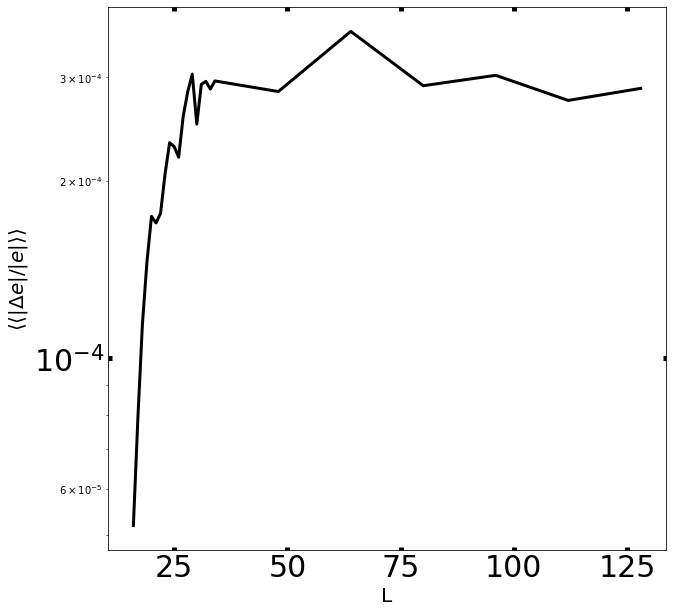

In [62]:
blocks=ls
plt.figure(figsize=(10,10))
plt.plot(blocks,[np.average(e,axis=-1) for e in de],color='black',linewidth=3)
plt.xlabel('L',fontsize=20)
plt.ylabel(r'$\langle \langle |\Delta e|/|e| \rangle \rangle$',fontsize=20)
plt.semilogy()
plt.tick_params(
            top=True,
            right=True,
            labeltop=False,
            labelright=False,
            direction="in",
            labelsize=30,
            width=5,
        )
plt.show()
#print(np.average(de,axis=-1))

Histograms

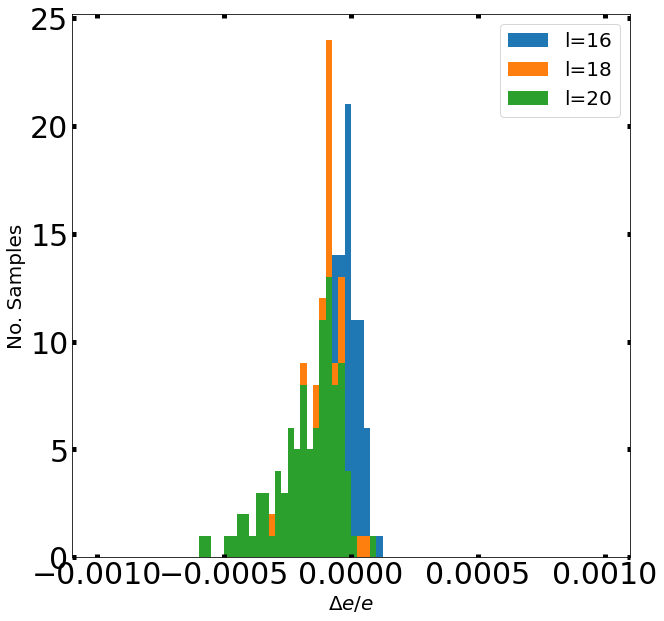

In [15]:
plt.figure(figsize=(10,10))
for i in range(0,6,2):
    plt.hist(de_diff[i],bins=80,label=f'l={ls[i]}',range=(-0.001,0.001))
plt.xlabel(r'$\Delta e/e$',fontsize=20)
plt.legend(fontsize=20)
plt.ylabel('No. Samples',fontsize=20)
plt.tick_params(
            top=True,
            right=True,
            labeltop=False,
            labelright=False,
            direction="in",
            labelsize=30,
            width=5,
        )

Magnetization

There is a discrepancy in the magnetization value even if the energy error seems to decrease (problem with DMRG again? Is due to the H-K mapping?)

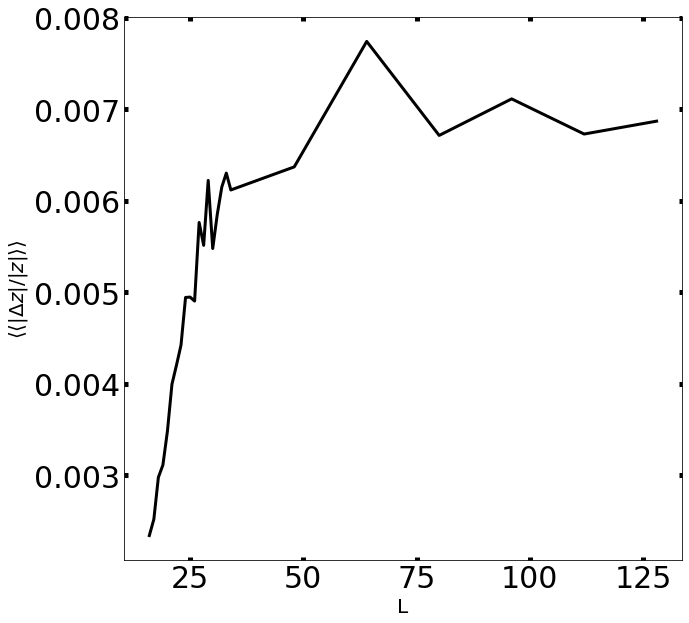

In [16]:
blocks=ls
plt.figure(figsize=(10,10))
plt.plot(blocks,[np.average(z,axis=-1) for z in dz],color='black',linewidth=3)
plt.xlabel('L',fontsize=20)
plt.ylabel(r'$\langle \langle |\Delta z|/|z| \rangle \rangle$',fontsize=20)
plt.tick_params(
            top=True,
            right=True,
            labeltop=False,
            labelright=False,
            direction="in",
            labelsize=30,
            width=5,
        )

plt.show()

Histograms

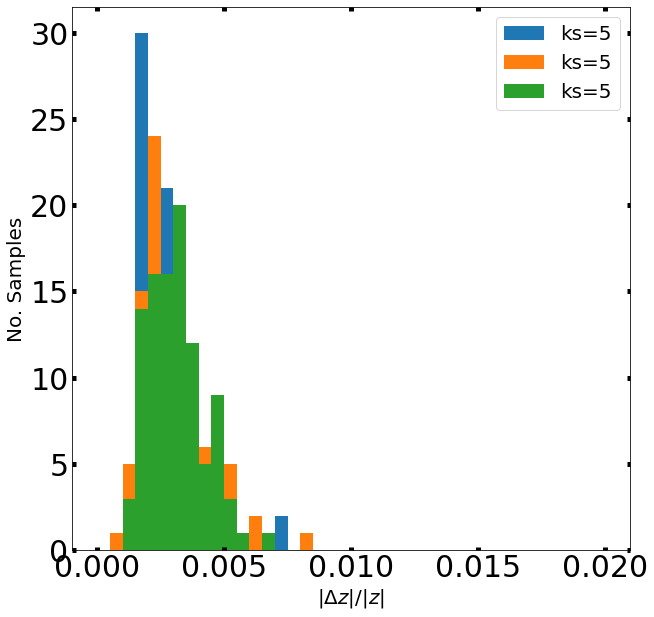

In [32]:
plt.figure(figsize=(10,10))
for i in range(1,4):
    plt.hist(dz[i],bins=40,label=f'ks={ks[i]}',range=(0,0.02))
plt.xlabel(r'$|\Delta z|/|z|$',fontsize=20)
plt.legend(fontsize=20)
plt.ylabel('No. Samples',fontsize=20)
plt.tick_params(
            top=True,
            right=True,
            labeltop=False,
            labelright=False,
            direction="in",
            labelsize=30,
            width=5,
        )

## DFT accuracy for different block for $l=64$

#### Imports

In [33]:
import os
import time
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
from scipy import fft, ifft
from tqdm.notebook import tqdm, trange
from src.training.utils_analysis import dataloader, nuv_representability_check,mean_field_functional_1nn

#### Data

In [34]:
n_sample=7
h_max=[5.44]*n_sample
ls=[64]*n_sample
n_instances=[100]*n_sample
epochs = [1900]*n_sample 
# model settings
name_session=[f'h_{h_max[i]}_15k_augmentation_2nn_model_unet_{ls[i]}_size_{i+2}_layers_40_hc_5_ks_1_ps' for i in range(n_sample)]
early_stopping=False
variational_lr=False
loglr=1

min_density={}
gs_density={}
min_energy={}
gs_energy={}
hs={}

for i in range(n_sample):
    min_eng=[]
    gs_eng=[]
    min_n=[]
    gs_n=[]
    hs[ls[i]]=np.load(f'data/dataset_2nn/test_dataset_221122/test_unet_periodic_2nn_{ls[i]}_l_{h_max[i]}_h_100_n.npz')['potential'][0:n_instances[i]]
    min_eng_t,gs_eng_t=dataloader('energy',session_name=name_session[i],n_instances=n_instances[i],lr=loglr,diff_soglia=1,epochs=epochs[i],early_stopping=False,variable_lr=False,n_ensambles=1)
    min_n_t,gs_n_t=dataloader('density',session_name=name_session[i],n_instances=n_instances[i],lr=loglr,diff_soglia=1,epochs=epochs[i],early_stopping=False,variable_lr=False,n_ensambles=1)
    
    min_eng_t=np.asarray(min_eng_t)
    gs_eng_t=np.asarray(gs_eng_t)
    min_n_t=np.asarray(min_n_t)
    gs_n_t=np.asarray(gs_n_t)

    
    if i==0:
        min_engs=min_eng_t.reshape(1,-1)
        gs_engs=gs_eng_t.reshape(1,-1)
        min_ns=min_n_t.reshape(1,-1,ls[i])
        gs_ns=gs_n_t.reshape(1,-1,ls[i])


    else:
        
        min_engs=np.append(min_engs,min_eng_t.reshape(1,-1),axis=0)
        gs_engs=np.append(gs_engs,gs_eng_t.reshape(1,-1),axis=0)
        min_ns=np.append(min_ns,min_n_t.reshape(1,-1,ls[i]),axis=0)
        gs_ns=np.append(gs_ns,gs_n_t.reshape(1,-1,ls[i]),axis=0)
        
        


In [35]:
print(min_engs.shape)
print(gs_engs.shape)

(7, 100)
(7, 100)


Compute the errors

In [36]:
de=np.abs(min_engs-gs_engs)/np.abs(gs_engs)
de_diff=(gs_engs-min_engs)/(gs_engs)
dz=np.average(np.abs(min_ns-gs_ns),axis=-1)/np.average(np.abs(gs_ns),axis=-1)


#### Steady values

Energy

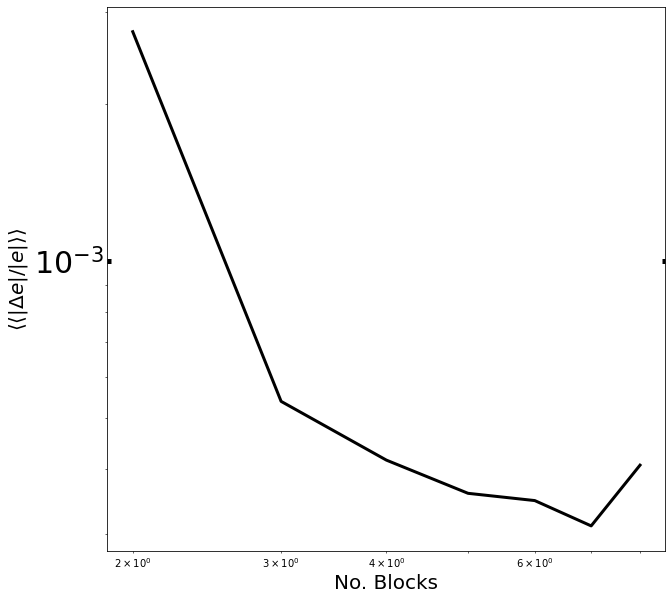

In [37]:
blocks=np.arange(2,9)
plt.figure(figsize=(10,10))
plt.plot(blocks,np.average(de,axis=-1),color='black',linewidth=3)
plt.xlabel('No. Blocks',fontsize=20)
plt.ylabel(r'$\langle \langle |\Delta e|/|e| \rangle \rangle$',fontsize=20)
plt.tick_params(
            top=True,
            right=True,
            labeltop=False,
            labelright=False,
            direction="in",
            labelsize=30,
            width=5,
        )
plt.loglog()
plt.show()

Histograms

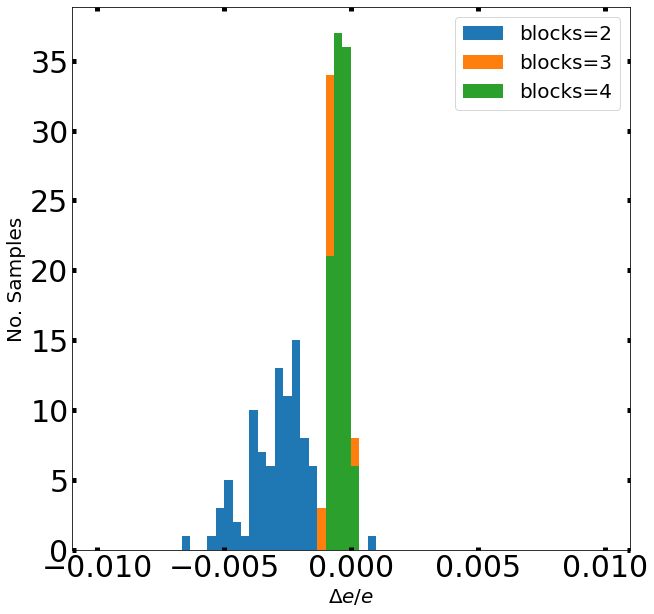

In [38]:
plt.figure(figsize=(10,10))
for i in range(3):
    plt.hist(de_diff[i],bins=60,label=f'blocks={2+i}',range=(-0.01,0.01))
plt.xlabel(r'$\Delta e/e$',fontsize=20)
plt.legend(fontsize=20)
plt.ylabel('No. Samples',fontsize=20)
plt.tick_params(
            top=True,
            right=True,
            labeltop=False,
            labelright=False,
            direction="in",
            labelsize=30,
            width=5,
        )

Magnetization

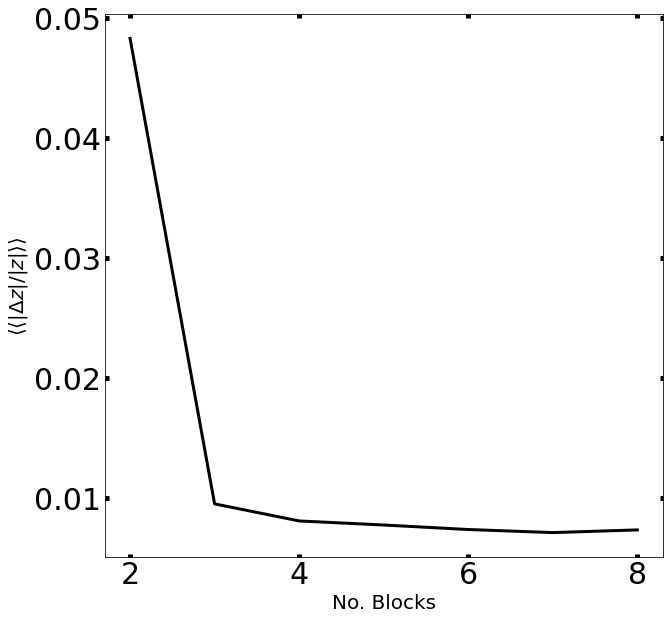

In [39]:
blocks=np.arange(2,9)
plt.figure(figsize=(10,10))
plt.plot(blocks,np.average(dz,axis=-1),color='black',linewidth=3)
plt.xlabel('No. Blocks',fontsize=20)
plt.ylabel(r'$\langle \langle |\Delta z|/|z| \rangle \rangle$',fontsize=20)
plt.tick_params(
            top=True,
            right=True,
            labeltop=False,
            labelright=False,
            direction="in",
            labelsize=30,
            width=5,
        )

plt.show()

Histograms

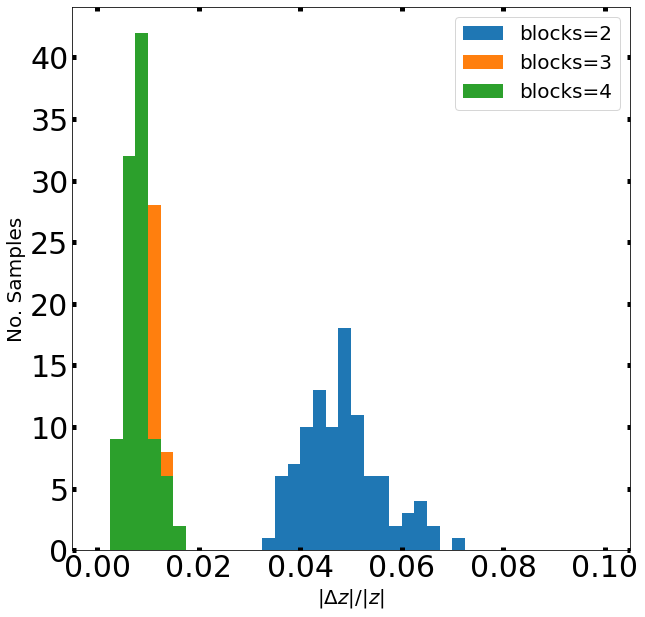

In [40]:
plt.figure(figsize=(10,10))
for i in range(3):
    plt.hist(dz[i],bins=40,label=f'blocks={2+i}',range=(0,0.1))
plt.xlabel(r'$|\Delta z|/|z|$',fontsize=20)
plt.legend(fontsize=20)
plt.ylabel('No. Samples',fontsize=20)
plt.tick_params(
            top=True,
            right=True,
            labeltop=False,
            labelright=False,
            direction="in",
            labelsize=30,
            width=5,
        )

## DFT accuracy for different kernel sizes for $l=64$

#### Imports

In [71]:
import os
import time
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
from scipy import fft, ifft
from tqdm.notebook import tqdm, trange
from src.training.utils_analysis import dataloader, nuv_representability_check,mean_field_functional_1nn

#### Data

In [72]:
ks=[1,3,5,7,9,11]
n_sample=len(ks)
h_max=[5.44]*n_sample
ls=[64]*n_sample
n_instances=[100]*n_sample
epochs = [1900]*n_sample 
# model settings
name_session=[f'h_{h_max[i]}_15k_augmentation_2nn_model_unet_{ls[i]}_size_4_layers_40_hc_{ks[i]}_ks_1_ps' for i in range(n_sample)]
early_stopping=False
variational_lr=False
loglr=1

min_density={}
gs_density={}
min_energy={}
gs_energy={}
hs={}

for i in range(n_sample):
    min_eng=[]
    gs_eng=[]
    min_n=[]
    gs_n=[]
    hs[ls[i]]=np.load(f'data/dataset_2nn/test_dataset_221122/test_unet_periodic_2nn_{ls[i]}_l_{h_max[i]}_h_100_n.npz')['potential'][0:n_instances[i]]
    min_eng_t,gs_eng_t=dataloader('energy',session_name=name_session[i],n_instances=n_instances[i],lr=loglr,diff_soglia=1,epochs=epochs[i],early_stopping=False,variable_lr=False,n_ensambles=1)
    min_n_t,gs_n_t=dataloader('density',session_name=name_session[i],n_instances=n_instances[i],lr=loglr,diff_soglia=1,epochs=epochs[i],early_stopping=False,variable_lr=False,n_ensambles=1)
    
    min_eng_t=np.asarray(min_eng_t)
    gs_eng_t=np.asarray(gs_eng_t)
    min_n_t=np.asarray(min_n_t)
    gs_n_t=np.asarray(gs_n_t)

    
    if i==0:
        min_engs=min_eng_t.reshape(1,-1)
        gs_engs=gs_eng_t.reshape(1,-1)
        min_ns=min_n_t.reshape(1,-1,ls[i])
        gs_ns=gs_n_t.reshape(1,-1,ls[i])


    else:
        
        min_engs=np.append(min_engs,min_eng_t.reshape(1,-1),axis=0)
        gs_engs=np.append(gs_engs,gs_eng_t.reshape(1,-1),axis=0)
        min_ns=np.append(min_ns,min_n_t.reshape(1,-1,ls[i]),axis=0)
        gs_ns=np.append(gs_ns,gs_n_t.reshape(1,-1,ls[i]),axis=0)
        
        


In [41]:
print(min_engs.shape)
print(gs_engs.shape)

(6, 100)
(6, 100)


Compute the errors

In [73]:
de=np.abs(min_engs-gs_engs)/np.abs(gs_engs)
de_diff=(gs_engs-min_engs)/(gs_engs)
dz=np.average(np.abs(min_ns-gs_ns),axis=-1)/np.average(np.abs(gs_ns),axis=-1)


#### Steady values

Energy

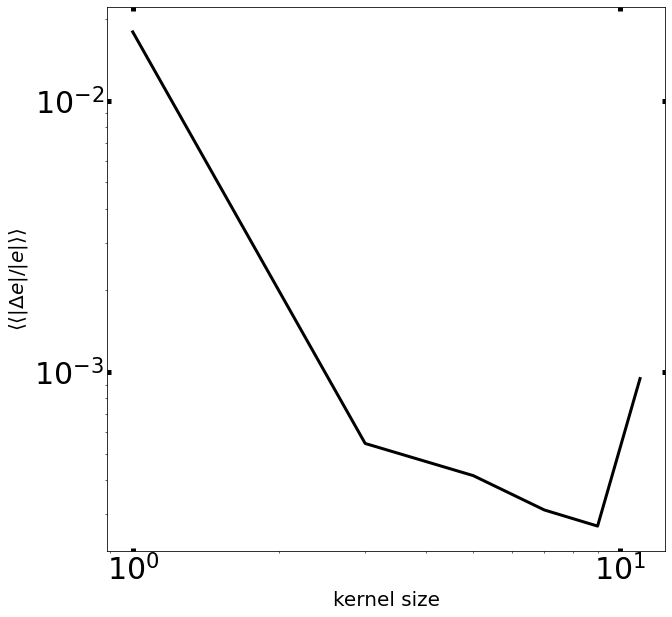

[0.01793701 0.00054591 0.00041552 0.00031039 0.00027076 0.00094691]


In [74]:
blocks=ks
plt.figure(figsize=(10,10))
plt.plot(blocks,np.average(de,axis=-1),color='black',linewidth=3)
plt.xlabel('kernel size',fontsize=20)
plt.ylabel(r'$\langle \langle |\Delta e|/|e| \rangle \rangle$',fontsize=20)
plt.loglog()
plt.tick_params(
            top=True,
            right=True,
            labeltop=False,
            labelright=False,
            direction="in",
            labelsize=30,
            width=5,
        )
plt.show()
print(np.average(de,axis=-1))

Histograms

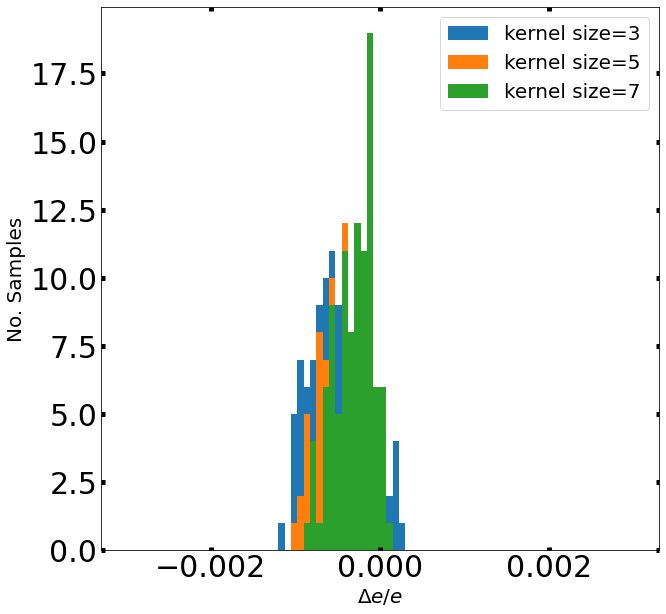

In [76]:
plt.figure(figsize=(10,10))
for i in range(1,4):
    plt.hist(de_diff[i],bins=80,label=f'kernel size={ks[i]}',range=(-0.003,0.003))
plt.xlabel(r'$\Delta e/e$',fontsize=20)
plt.legend(fontsize=20)
plt.ylabel('No. Samples',fontsize=20)
plt.tick_params(
            top=True,
            right=True,
            labeltop=False,
            labelright=False,
            direction="in",
            labelsize=30,
            width=5,
        )

Magnetization

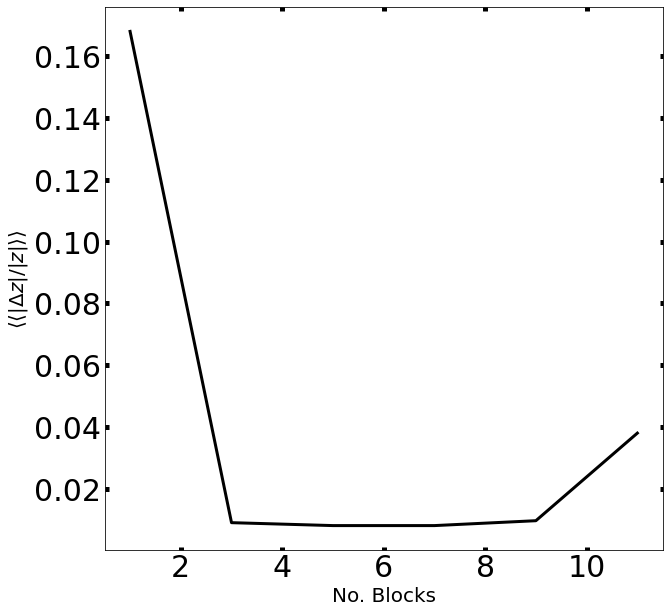

In [59]:
blocks=ks
plt.figure(figsize=(10,10))
plt.plot(blocks,np.average(dz,axis=-1),color='black',linewidth=3)
plt.xlabel('No. Blocks',fontsize=20)
plt.ylabel(r'$\langle \langle |\Delta z|/|z| \rangle \rangle$',fontsize=20)
plt.tick_params(
            top=True,
            right=True,
            labeltop=False,
            labelright=False,
            direction="in",
            labelsize=30,
            width=5,
        )

plt.show()

Histograms

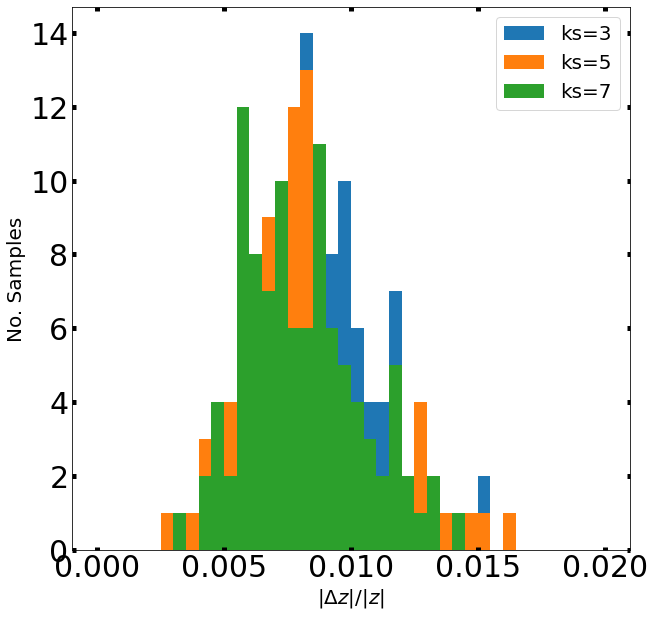

In [62]:
plt.figure(figsize=(10,10))
for i in range(1,4):
    plt.hist(dz[i],bins=40,label=f'ks={ks[i]}',range=(0,0.02))
plt.xlabel(r'$|\Delta z|/|z|$',fontsize=20)
plt.legend(fontsize=20)
plt.ylabel('No. Samples',fontsize=20)
plt.tick_params(
            top=True,
            right=True,
            labeltop=False,
            labelright=False,
            direction="in",
            labelsize=30,
            width=5,
        )

#### Imports

In [2]:
import os
import time
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
from scipy import fft, ifft
from tqdm.notebook import tqdm, trange
from src.training.utils_analysis import dataloader, nuv_representability_check,mean_field_functional_1nn

#### Data

In [10]:
n_sample=7
h_max=[5.44]*n_sample
ls=[64]*n_sample
n_instances=[100]*n_sample
epochs = [1900]*n_sample 
# model settings
name_session=[f'h_{h_max[i]}_15k_augmentation_2nn_model_unet_{ls[i]}_size_{i+2}_layers_40_hc_5_ks_1_ps' for i in range(n_sample)]
early_stopping=False
variational_lr=False
loglr=1

min_density={}
gs_density={}
min_energy={}
gs_energy={}
hs={}

for i in range(n_sample):
    min_eng=[]
    gs_eng=[]
    min_n=[]
    gs_n=[]
    hs[ls[i]]=np.load(f'data/dataset_2nn/test_dataset_221122/test_unet_periodic_2nn_{ls[i]}_l_{h_max[i]}_h_100_n.npz')['potential'][0:n_instances[i]]
    min_eng_t,gs_eng_t=dataloader('energy',session_name=name_session[i],n_instances=n_instances[i],lr=loglr,diff_soglia=1,epochs=epochs[i],early_stopping=False,variable_lr=False,n_ensambles=1)
    min_n_t,gs_n_t=dataloader('density',session_name=name_session[i],n_instances=n_instances[i],lr=loglr,diff_soglia=1,epochs=epochs[i],early_stopping=False,variable_lr=False,n_ensambles=1)
    
    min_eng_t=np.asarray(min_eng_t)
    gs_eng_t=np.asarray(gs_eng_t)
    min_n_t=np.asarray(min_n_t)
    gs_n_t=np.asarray(gs_n_t)

    
    if i==0:
        min_engs=min_eng_t.reshape(1,-1)
        gs_engs=gs_eng_t.reshape(1,-1)
        min_ns=min_n_t.reshape(1,-1,ls[i])
        gs_ns=gs_n_t.reshape(1,-1,ls[i])


    else:
        
        min_engs=np.append(min_engs,min_eng_t.reshape(1,-1),axis=0)
        gs_engs=np.append(gs_engs,gs_eng_t.reshape(1,-1),axis=0)
        min_ns=np.append(min_ns,min_n_t.reshape(1,-1,ls[i]),axis=0)
        gs_ns=np.append(gs_ns,gs_n_t.reshape(1,-1,ls[i]),axis=0)
        
        


In [11]:
print(min_engs.shape)
print(gs_engs.shape)

(7, 100)
(7, 100)


Compute the errors

In [32]:
de=np.abs(min_engs-gs_engs)/np.abs(gs_engs)
de_diff=(gs_engs-min_engs)/(gs_engs)
dz=np.average(np.abs(min_ns-gs_ns),axis=-1)/np.average(np.abs(gs_ns),axis=-1)


#### Steady values

Energy

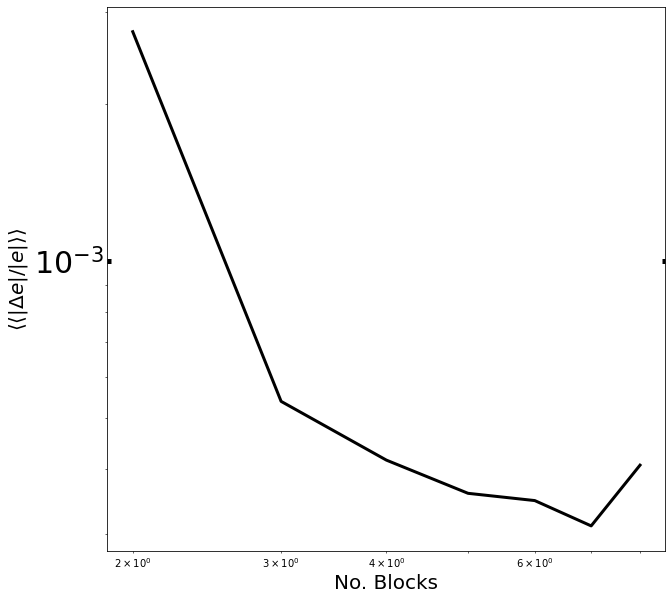

In [41]:
blocks=np.arange(2,9)
plt.figure(figsize=(10,10))
plt.plot(blocks,np.average(de,axis=-1),color='black',linewidth=3)
plt.xlabel('No. Blocks',fontsize=20)
plt.ylabel(r'$\langle \langle |\Delta e|/|e| \rangle \rangle$',fontsize=20)
plt.tick_params(
            top=True,
            right=True,
            labeltop=False,
            labelright=False,
            direction="in",
            labelsize=30,
            width=5,
        )
plt.loglog()
plt.show()

Histograms

Text(0, 0.5, 'No. Samples')

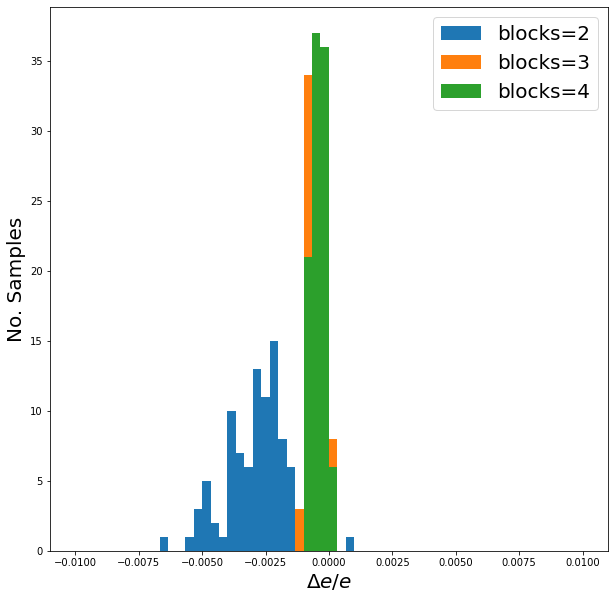

In [35]:
plt.figure(figsize=(10,10))
for i in range(3):
    plt.hist(de_diff[i],bins=60,label=f'blocks={2+i}',range=(-0.01,0.01))
plt.xlabel(r'$\Delta e/e$',fontsize=20)
plt.legend(fontsize=20)
plt.ylabel('No. Samples',fontsize=20)
plt.tick_params(
            top=True,
            right=True,
            labeltop=False,
            labelright=False,
            direction="in",
            labelsize=30,
            width=5,
        )

Magnetization

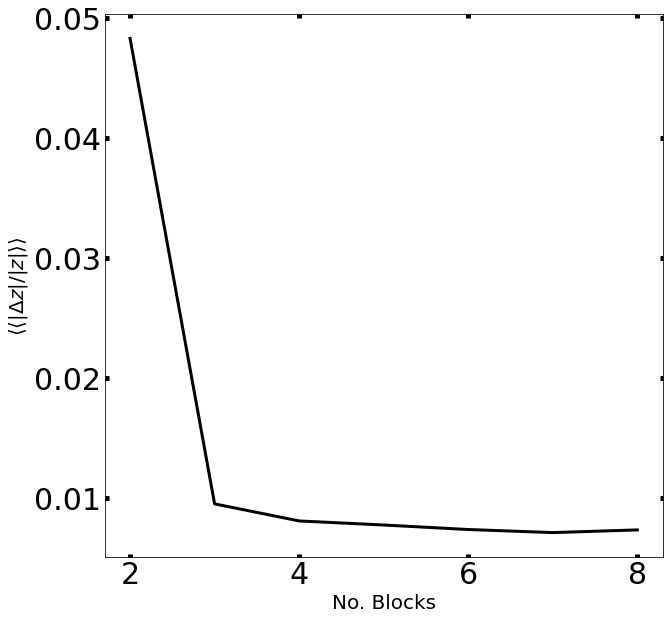

In [34]:
blocks=np.arange(2,9)
plt.figure(figsize=(10,10))
plt.plot(blocks,np.average(dz,axis=-1),color='black',linewidth=3)
plt.xlabel('No. Blocks',fontsize=20)
plt.ylabel(r'$\langle \langle |\Delta z|/|z| \rangle \rangle$',fontsize=20)
plt.tick_params(
            top=True,
            right=True,
            labeltop=False,
            labelright=False,
            direction="in",
            labelsize=30,
            width=5,
        )

plt.show()

Histograms

Text(0, 0.5, 'No. Samples')

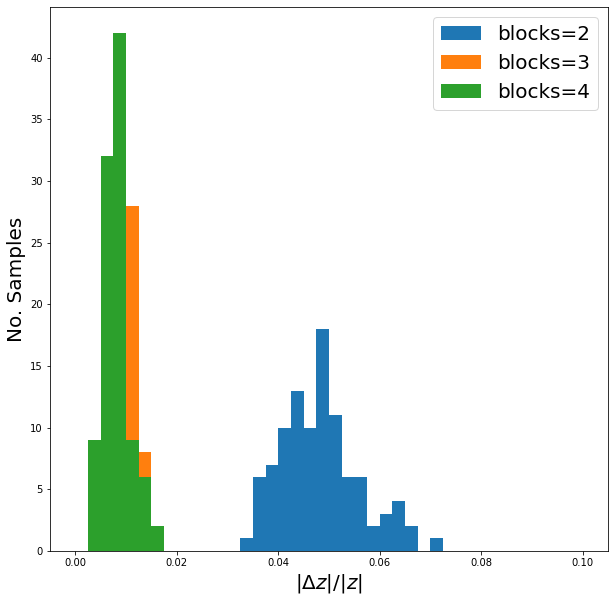

In [38]:
plt.figure(figsize=(10,10))
for i in range(3):
    plt.hist(dz[i],bins=40,label=f'blocks={2+i}',range=(0,0.1))
plt.xlabel(r'$|\Delta z|/|z|$',fontsize=20)
plt.legend(fontsize=20)
plt.ylabel('No. Samples',fontsize=20)
plt.tick_params(
            top=True,
            right=True,
            labeltop=False,
            labelright=False,
            direction="in",
            labelsize=30,
            width=5,
        )

## DFT accuracy for different disorder for $l=64$

#### Imports

In [2]:
import os
import time
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
from scipy import fft, ifft
from tqdm.notebook import tqdm, trange
from src.training.utils_analysis import dataloader, nuv_representability_check,mean_field_functional_1nn

#### Data

In [ ]:
h_max=[2.4,3.6,5.44,7.2,8.4]
ks=[5]*len(h_max)
n_sample=len(ks)
#h_max=[5.44]*n_sample
ls=[16]*n_sample
n_instances=[100]*n_sample
epochs = [1900]*n_sample 
# model settings
name_session=[f'h_{h_max[i]}_15k_augmentation_2nn_model_unet_{ls[i]}_size_4_layers_40_hc_{ks[i]}_ks_1_ps' for i in range(n_sample)]
early_stopping=False
variational_lr=False
loglr=1

min_density={}
gs_density={}
min_energy={}
gs_energy={}
hs={}

for i in range(n_sample):
    min_eng=[]
    gs_eng=[]
    min_n=[]
    gs_n=[]
    hs[ls[i]]=np.load(f'data/dataset_2nn/test_unet_periodic_2nn_{ls[i]}_l_{h_max[i]}_h_100_n.npz')['potential'][0:n_instances[i]]
    min_eng_t,gs_eng_t=dataloader('energy',session_name=name_session[i],n_instances=n_instances[i],lr=loglr,diff_soglia=1,epochs=epochs[i],early_stopping=False,variable_lr=False,n_ensambles=1)
    min_n_t,gs_n_t=dataloader('density',session_name=name_session[i],n_instances=n_instances[i],lr=loglr,diff_soglia=1,epochs=epochs[i],early_stopping=False,variable_lr=False,n_ensambles=1)
    
    min_eng_t=np.asarray(min_eng_t)
    gs_eng_t=np.asarray(gs_eng_t)
    min_n_t=np.asarray(min_n_t)
    gs_n_t=np.asarray(gs_n_t)

    
    if i==0:
        min_engs=min_eng_t.reshape(1,-1)
        gs_engs=gs_eng_t.reshape(1,-1)
        min_ns=min_n_t.reshape(1,-1,ls[i])
        gs_ns=gs_n_t.reshape(1,-1,ls[i])


    else:
        
        min_engs=np.append(min_engs,min_eng_t.reshape(1,-1),axis=0)
        gs_engs=np.append(gs_engs,gs_eng_t.reshape(1,-1),axis=0)
        min_ns=np.append(min_ns,min_n_t.reshape(1,-1,ls[i]),axis=0)
        gs_ns=np.append(gs_ns,gs_n_t.reshape(1,-1,ls[i]),axis=0)
        
        


In [ ]:
print(min_engs.shape)
print(gs_engs.shape)

(6, 100)
(6, 100)


Compute the errors

In [ ]:
de=np.abs(min_engs-gs_engs)/np.abs(gs_engs)
de_diff=(gs_engs-min_engs)/(gs_engs)
dz=np.average(np.abs(min_ns-gs_ns),axis=-1)/np.average(np.abs(gs_ns),axis=-1)


#### Steady values

Energy

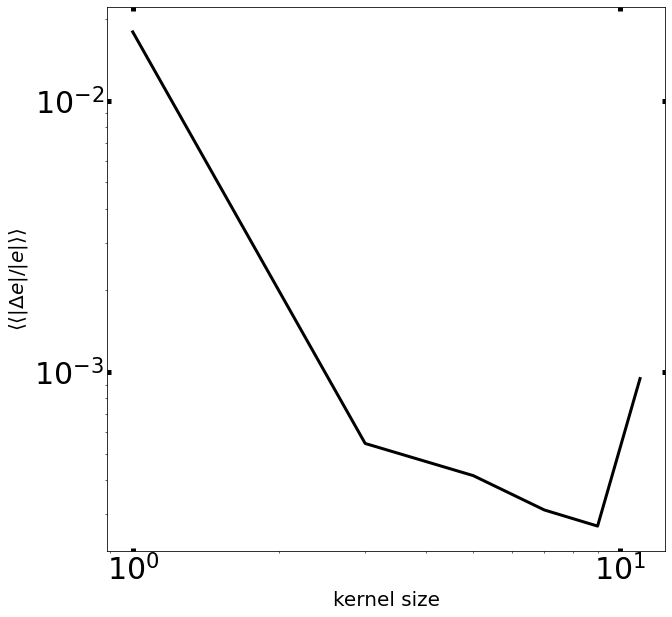

[0.01793701 0.00054591 0.00041552 0.00031039 0.00027076 0.00094691]


In [ ]:
blocks=ks
plt.figure(figsize=(10,10))
plt.plot(blocks,np.average(de,axis=-1),color='black',linewidth=3)
plt.xlabel('kernel size',fontsize=20)
plt.ylabel(r'$\langle \langle |\Delta e|/|e| \rangle \rangle$',fontsize=20)
plt.loglog()
plt.tick_params(
            top=True,
            right=True,
            labeltop=False,
            labelright=False,
            direction="in",
            labelsize=30,
            width=5,
        )
plt.show()
print(np.average(de,axis=-1))

Histograms

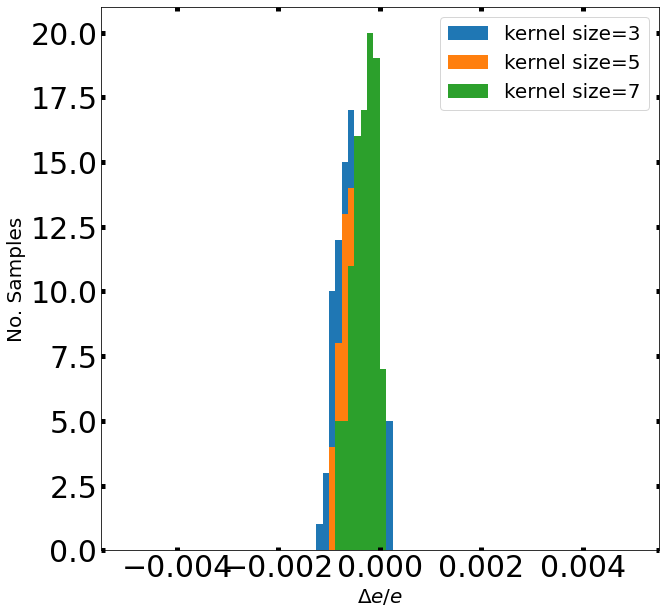

In [ ]:
plt.figure(figsize=(10,10))
for i in range(1,4):
    plt.hist(de_diff[i],bins=80,label=f'kernel size={ks[i]}',range=(-0.005,0.005))
plt.xlabel(r'$\Delta e/e$',fontsize=20)
plt.legend(fontsize=20)
plt.ylabel('No. Samples',fontsize=20)
plt.tick_params(
            top=True,
            right=True,
            labeltop=False,
            labelright=False,
            direction="in",
            labelsize=30,
            width=5,
        )

Magnetization

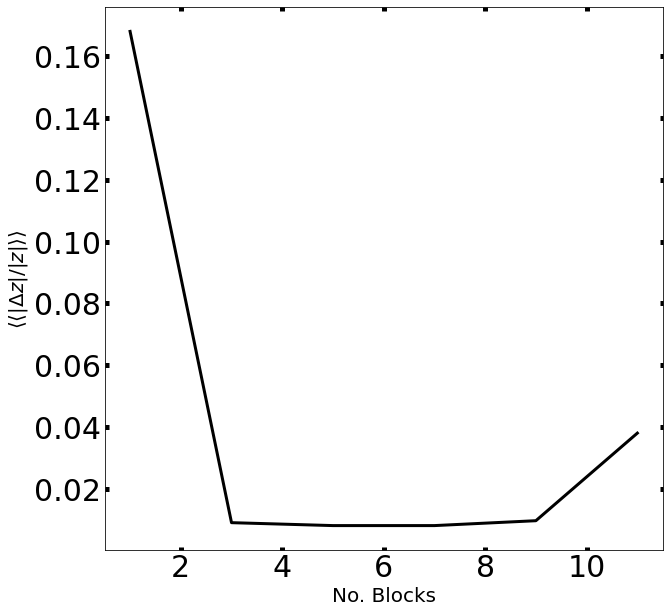

In [ ]:
blocks=ks
plt.figure(figsize=(10,10))
plt.plot(blocks,np.average(dz,axis=-1),color='black',linewidth=3)
plt.xlabel('No. Blocks',fontsize=20)
plt.ylabel(r'$\langle \langle |\Delta z|/|z| \rangle \rangle$',fontsize=20)
plt.tick_params(
            top=True,
            right=True,
            labeltop=False,
            labelright=False,
            direction="in",
            labelsize=30,
            width=5,
        )

plt.show()

Histograms

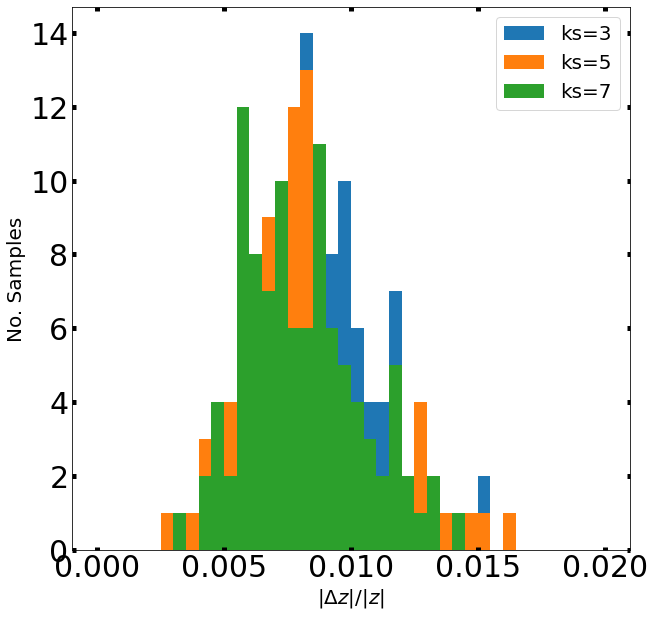

In [ ]:
plt.figure(figsize=(10,10))
for i in range(1,4):
    plt.hist(dz[i],bins=40,label=f'ks={ks[i]}',range=(0,0.02))
plt.xlabel(r'$|\Delta z|/|z|$',fontsize=20)
plt.legend(fontsize=20)
plt.ylabel('No. Samples',fontsize=20)
plt.tick_params(
            top=True,
            right=True,
            labeltop=False,
            labelright=False,
            direction="in",
            labelsize=30,
            width=5,
        )

## DFT analysis with different disorder

#### Imports

In [1]:
import os
import time
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
from scipy import fft, ifft
from tqdm.notebook import tqdm, trange
from src.training.utils_analysis import dataloader, nuv_representability_check,mean_field_functional_1nn

#### Data

In [77]:
h_max=[2.4,3.6,5.44,7.2]
n_sample=len(h_max)
ls=[64]*n_sample
n_instances=[100]*n_sample
epochs = [1900]*n_sample 
# model settings
name_session=[f'h_{h_max[i]}_15k_augmentation_2nn_model_unet_{ls[i]}_size_4_layers_40_hc_5_ks_1_ps' for i in range(n_sample)]
early_stopping=False
variational_lr=False
loglr=1

min_density={}
gs_density={}
min_energy={}
gs_energy={}
hs={}

for i in range(n_sample):
    min_eng=[]
    gs_eng=[]
    min_n=[]
    gs_n=[]
    hs[ls[i]]=np.load(f'data/dataset_2nn/test_unet_periodic_2nn_{ls[i]}_l_{h_max[i]}_h_100_n.npz')['potential'][0:n_instances[i]]
    min_eng_t,gs_eng_t=dataloader('energy',session_name=name_session[i],n_instances=n_instances[i],lr=loglr,diff_soglia=1,epochs=epochs[i],early_stopping=False,variable_lr=False,n_ensambles=1)
    min_n_t,gs_n_t=dataloader('density',session_name=name_session[i],n_instances=n_instances[i],lr=loglr,diff_soglia=1,epochs=epochs[i],early_stopping=False,variable_lr=False,n_ensambles=1)
    
    min_eng_t=np.asarray(min_eng_t)
    gs_eng_t=np.asarray(gs_eng_t)
    min_n_t=np.asarray(min_n_t)
    gs_n_t=np.asarray(gs_n_t)

    
    if i==0:
        min_engs=min_eng_t.reshape(1,-1)
        gs_engs=gs_eng_t.reshape(1,-1)
        min_ns=min_n_t.reshape(1,-1,ls[i])
        gs_ns=gs_n_t.reshape(1,-1,ls[i])


    else:
        
        min_engs=np.append(min_engs,min_eng_t.reshape(1,-1),axis=0)
        gs_engs=np.append(gs_engs,gs_eng_t.reshape(1,-1),axis=0)
        min_ns=np.append(min_ns,min_n_t.reshape(1,-1,ls[i]),axis=0)
        gs_ns=np.append(gs_ns,gs_n_t.reshape(1,-1,ls[i]),axis=0)
        
        


In [3]:
print(min_engs.shape)
print(gs_engs.shape)

(5, 100)
(5, 100)


Compute the errors

In [78]:
de=np.abs(min_engs-gs_engs)/np.abs(gs_engs)
de_diff=(gs_engs-min_engs)/(gs_engs)
dz=np.average(np.abs(min_ns-gs_ns),axis=-1)/np.average(np.abs(gs_ns),axis=-1)


#### Steady values

Energy

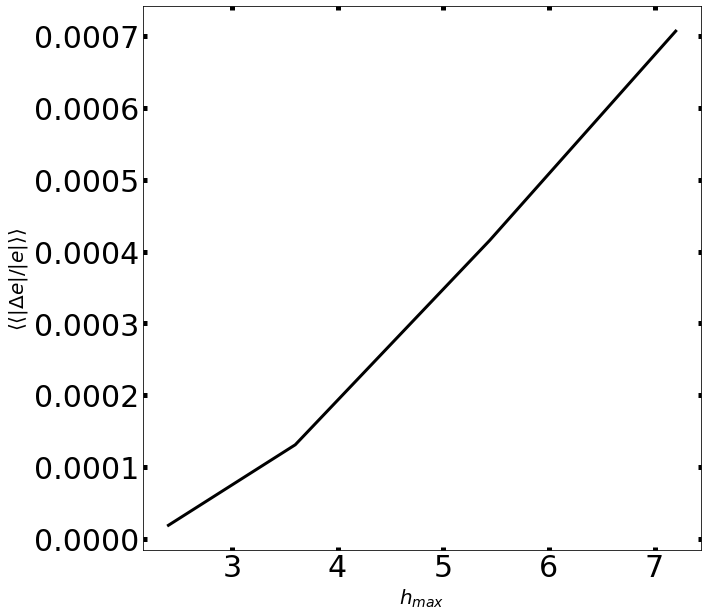

In [79]:
blocks=np.arange(2,9)
plt.figure(figsize=(10,10))
plt.plot(h_max,np.average(de,axis=-1),color='black',linewidth=3)
plt.xlabel(r'$h_{max}$',fontsize=20)
plt.ylabel(r'$\langle \langle |\Delta e|/|e| \rangle \rangle$',fontsize=20)
plt.tick_params(
            top=True,
            right=True,
            labeltop=False,
            labelright=False,
            direction="in",
            labelsize=30,
            width=5,
        )
#plt.loglog()
plt.show()

Histograms

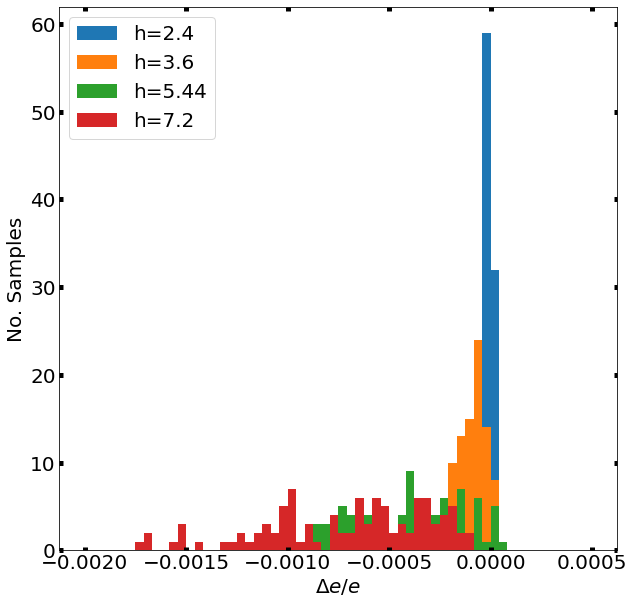

In [86]:
plt.figure(figsize=(10,10))
for i in range(4):
    plt.hist(de_diff[i],bins=60,label=f'h={h_max[i]}',range=(-0.002,0.0005))
plt.xlabel(r'$\Delta e/e$',fontsize=20)
plt.legend(fontsize=20)
plt.ylabel('No. Samples',fontsize=20)
plt.tick_params(
            top=True,
            right=True,
            labeltop=False,
            labelright=False,
            direction="in",
            labelsize=20,
            width=5,
        )

Magnetization

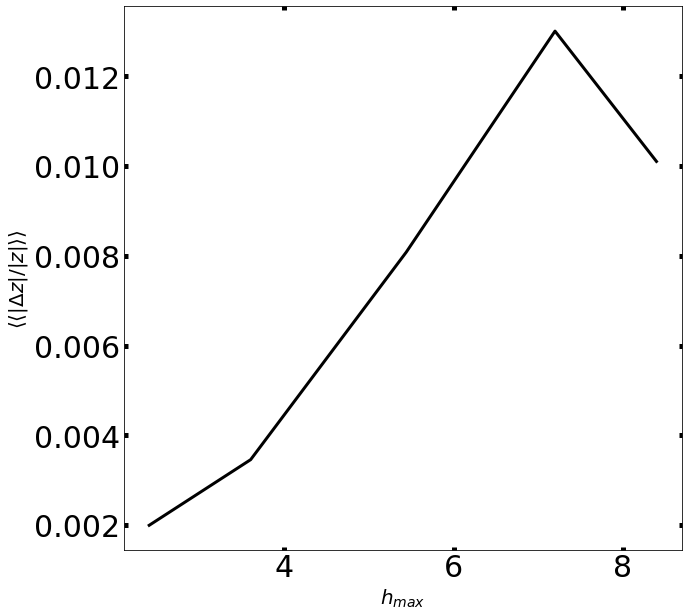

In [11]:
blocks=np.arange(2,9)
plt.figure(figsize=(10,10))
plt.plot(h_max,np.average(dz,axis=-1),color='black',linewidth=3)
plt.xlabel(r'$h_{max}$',fontsize=20)
plt.ylabel(r'$\langle \langle |\Delta z|/|z| \rangle \rangle$',fontsize=20)
plt.tick_params(
            top=True,
            right=True,
            labeltop=False,
            labelright=False,
            direction="in",
            labelsize=30,
            width=5,
        )

plt.show()

Histograms

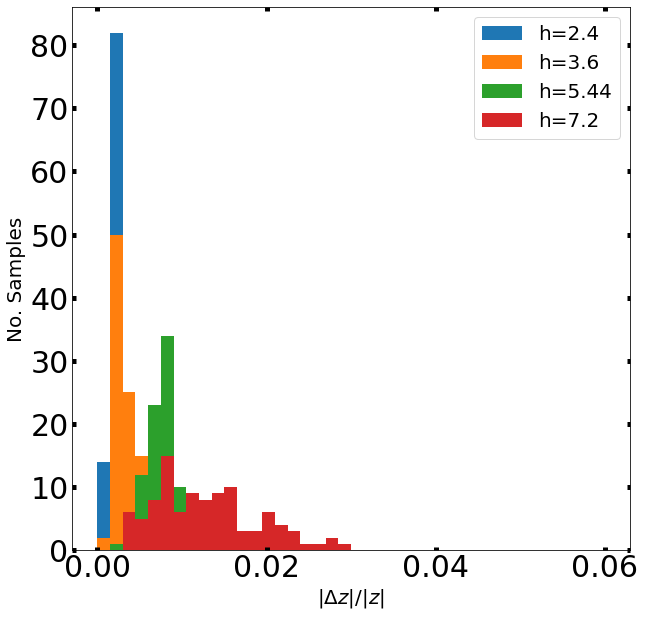

In [88]:
plt.figure(figsize=(10,10))
for i in range(4):
    plt.hist(dz[i],bins=40,label=f'h={h_max[i]}',range=(0,0.06))
plt.xlabel(r'$|\Delta z|/|z|$',fontsize=20)
plt.legend(fontsize=20)
plt.ylabel('No. Samples',fontsize=20)
plt.tick_params(
            top=True,
            right=True,
            labeltop=False,
            labelright=False,
            direction="in",
            labelsize=30,
            width=5,
        )

# Analysis of Density Functional Theory in a Ising model with 1nn interaction

## DFT accuracy for different kernel sizes for $l=64$

#### Imports

In [29]:
import os
import time
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
from scipy import fft, ifft
from tqdm.notebook import tqdm, trange
from src.training.utils_analysis import dataloader, nuv_representability_check,mean_field_functional_1nn

#### Data

In [31]:
ks=[1,3,5,7,9]
n_sample=len(ks)
h_max=[2.7]*n_sample
ls=[64]*n_sample
n_instances=[100]*n_sample
epochs = [1900]*n_sample 
# model settings
name_session=[f'h_{h_max[i]}_15k_augmentation_1nn_model_unet_{ls[i]}_size_4_layers_40_hc_{ks[i]}_ks_1_ps' for i in range(n_sample)]
early_stopping=False
variational_lr=False
loglr=1

min_density={}
gs_density={}
min_energy={}
gs_energy={}
hs={}

for i in range(n_sample):
    min_eng=[]
    gs_eng=[]
    min_n=[]
    gs_n=[]
    hs[ls[i]]=np.load(f'data/dataset_1nn/field2density_221122/valid_unet_periodic_{ls[i]}_l_{h_max[i]}_h_200_n.npz')['potential'][0:n_instances[i]]
    min_eng_t,gs_eng_t=dataloader('energy',session_name=name_session[i],n_instances=n_instances[i],lr=loglr,diff_soglia=1,epochs=epochs[i],early_stopping=False,variable_lr=False,n_ensambles=1)
    min_n_t,gs_n_t=dataloader('density',session_name=name_session[i],n_instances=n_instances[i],lr=loglr,diff_soglia=1,epochs=epochs[i],early_stopping=False,variable_lr=False,n_ensambles=1)
    
    min_eng_t=np.asarray(min_eng_t)
    gs_eng_t=np.asarray(gs_eng_t)
    min_n_t=np.asarray(min_n_t)
    gs_n_t=np.asarray(gs_n_t)

    
    if i==0:
        min_engs=min_eng_t.reshape(1,-1)
        gs_engs=gs_eng_t.reshape(1,-1)
        min_ns=min_n_t.reshape(1,-1,ls[i])
        gs_ns=gs_n_t.reshape(1,-1,ls[i])


    else:
        
        min_engs=np.append(min_engs,min_eng_t.reshape(1,-1),axis=0)
        gs_engs=np.append(gs_engs,gs_eng_t.reshape(1,-1),axis=0)
        min_ns=np.append(min_ns,min_n_t.reshape(1,-1,ls[i]),axis=0)
        gs_ns=np.append(gs_ns,gs_n_t.reshape(1,-1,ls[i]),axis=0)
        
        


In [17]:
print(min_engs.shape)
print(gs_engs.shape)

(6, 100)
(6, 100)


Compute the errors

In [32]:
de=np.abs(min_engs-gs_engs)/np.abs(gs_engs)
de_diff=(gs_engs-min_engs)/(gs_engs)
dz=np.average(np.abs(min_ns-gs_ns),axis=-1)/np.average(np.abs(gs_ns),axis=-1)


#### Steady values

Energy

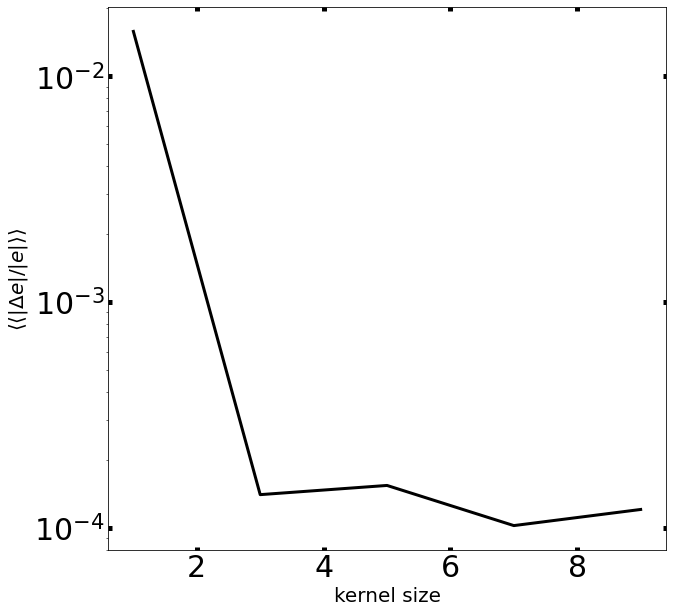

[0.01581429 0.00014008 0.00015386 0.00010214 0.00012041]


In [33]:
blocks=ks
plt.figure(figsize=(10,10))
plt.plot(blocks,np.average(de,axis=-1),color='black',linewidth=3)
plt.xlabel('kernel size',fontsize=20)
plt.ylabel(r'$\langle \langle |\Delta e|/|e| \rangle \rangle$',fontsize=20)
plt.semilogy()
plt.tick_params(
            top=True,
            right=True,
            labeltop=False,
            labelright=False,
            direction="in",
            labelsize=30,
            width=5,
        )
plt.show()
print(np.average(de,axis=-1))

Histograms

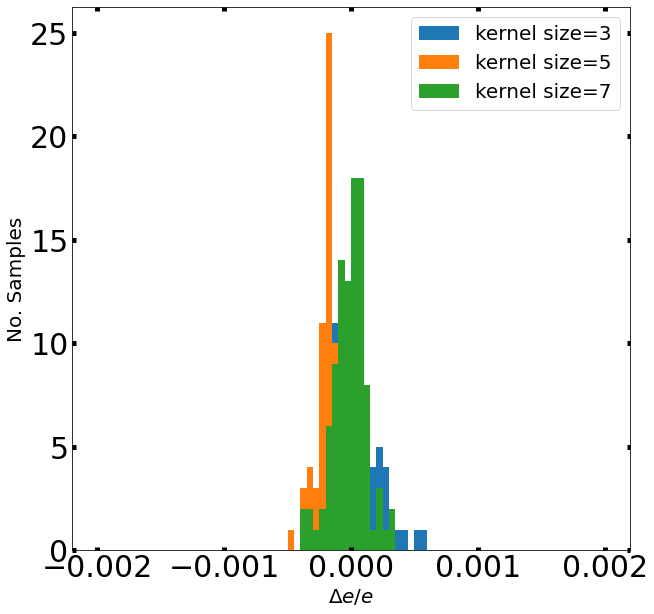

In [35]:
plt.figure(figsize=(10,10))
for i in range(1,4):
    plt.hist(de_diff[i],bins=80,label=f'kernel size={ks[i]}',range=(-0.002,0.002))
plt.xlabel(r'$\Delta e/e$',fontsize=20)
plt.legend(fontsize=20)
plt.ylabel('No. Samples',fontsize=20)
plt.tick_params(
            top=True,
            right=True,
            labeltop=False,
            labelright=False,
            direction="in",
            labelsize=30,
            width=5,
        )

Magnetization

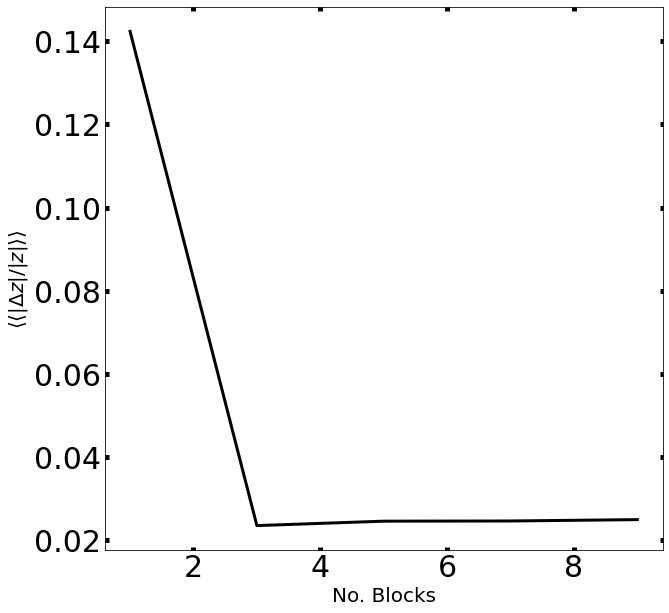

In [34]:
blocks=ks
plt.figure(figsize=(10,10))
plt.plot(blocks,np.average(dz,axis=-1),color='black',linewidth=3)
plt.xlabel('No. Blocks',fontsize=20)
plt.ylabel(r'$\langle \langle |\Delta z|/|z| \rangle \rangle$',fontsize=20)
plt.tick_params(
            top=True,
            right=True,
            labeltop=False,
            labelright=False,
            direction="in",
            labelsize=30,
            width=5,
        )

plt.show()

Histograms

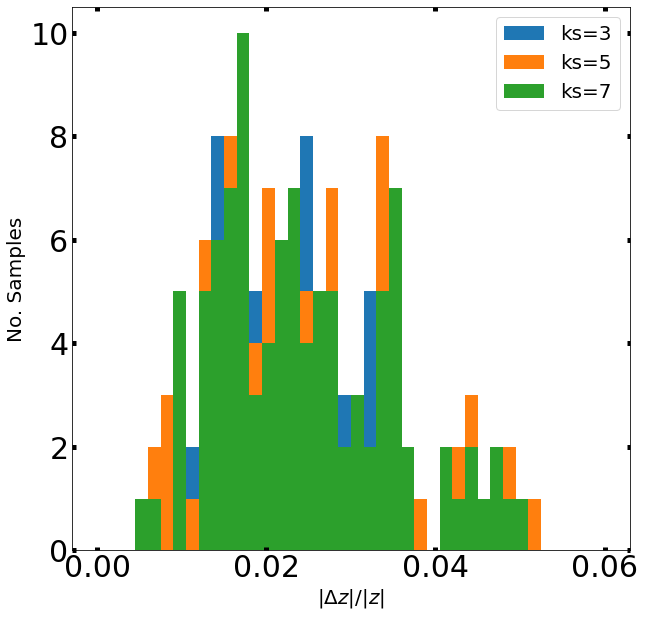

In [37]:
plt.figure(figsize=(10,10))
for i in range(1,4):
    plt.hist(dz[i],bins=40,label=f'ks={ks[i]}',range=(0,0.06))
plt.xlabel(r'$|\Delta z|/|z|$',fontsize=20)
plt.legend(fontsize=20)
plt.ylabel('No. Samples',fontsize=20)
plt.tick_params(
            top=True,
            right=True,
            labeltop=False,
            labelright=False,
            direction="in",
            labelsize=30,
            width=5,
        )

## DFT accuracy for different block for $l=16$

#### Imports

In [ ]:
import os
import time
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
from scipy import fft, ifft
from tqdm.notebook import tqdm, trange
from src.training.utils_analysis import dataloader, nuv_representability_check,mean_field_functional_1nn

#### Data

In [ ]:
n_sample=7
h_max=[2.7]*n_sample
ls=[16]*n_sample
n_instances=[100]*n_sample
epochs = [1900]*n_sample 
# model settings
name_session=[f'h_{h_max[i]}_15k_augmentation_2nn_model_unet_{ls[i]}_size_{i+2}_layers_40_hc_5_ks_1_ps' for i in range(n_sample)]
early_stopping=False
variational_lr=False
loglr=1

min_density={}
gs_density={}
min_energy={}
gs_energy={}
hs={}

for i in range(n_sample):
    min_eng=[]
    gs_eng=[]
    min_n=[]
    gs_n=[]
    hs[ls[i]]=np.load(f'data/dataset_2nn/test_dataset_221122/test_unet_periodic_2nn_{ls[i]}_l_{h_max[i]}_h_100_n.npz')['potential'][0:n_instances[i]]
    min_eng_t,gs_eng_t=dataloader('energy',session_name=name_session[i],n_instances=n_instances[i],lr=loglr,diff_soglia=1,epochs=epochs[i],early_stopping=False,variable_lr=False,n_ensambles=1)
    min_n_t,gs_n_t=dataloader('density',session_name=name_session[i],n_instances=n_instances[i],lr=loglr,diff_soglia=1,epochs=epochs[i],early_stopping=False,variable_lr=False,n_ensambles=1)
    
    min_eng_t=np.asarray(min_eng_t)
    gs_eng_t=np.asarray(gs_eng_t)
    min_n_t=np.asarray(min_n_t)
    gs_n_t=np.asarray(gs_n_t)

    
    if i==0:
        min_engs=min_eng_t.reshape(1,-1)
        gs_engs=gs_eng_t.reshape(1,-1)
        min_ns=min_n_t.reshape(1,-1,ls[i])
        gs_ns=gs_n_t.reshape(1,-1,ls[i])


    else:
        
        min_engs=np.append(min_engs,min_eng_t.reshape(1,-1),axis=0)
        gs_engs=np.append(gs_engs,gs_eng_t.reshape(1,-1),axis=0)
        min_ns=np.append(min_ns,min_n_t.reshape(1,-1,ls[i]),axis=0)
        gs_ns=np.append(gs_ns,gs_n_t.reshape(1,-1,ls[i]),axis=0)
        
        


In [ ]:
print(min_engs.shape)
print(gs_engs.shape)

(7, 100)
(7, 100)


Compute the errors

In [ ]:
de=np.abs(min_engs-gs_engs)/np.abs(gs_engs)
de_diff=(gs_engs-min_engs)/(gs_engs)
dz=np.average(np.abs(min_ns-gs_ns),axis=-1)/np.average(np.abs(gs_ns),axis=-1)


#### Steady values

Energy

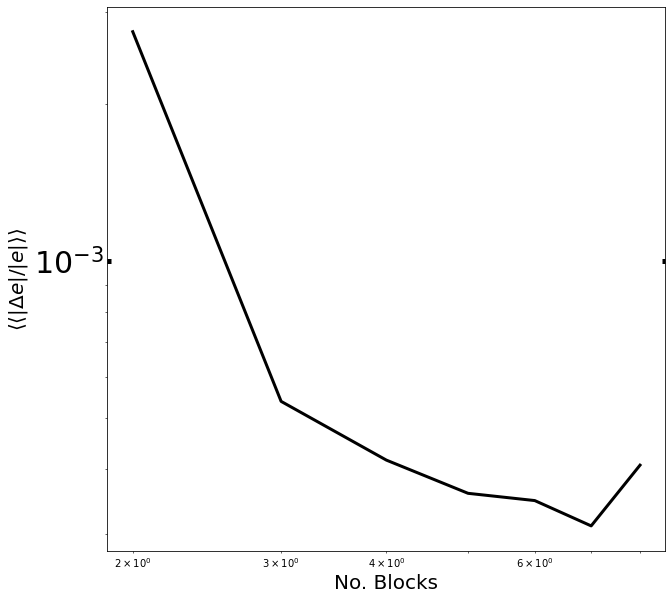

In [ ]:
blocks=np.arange(2,9)
plt.figure(figsize=(10,10))
plt.plot(blocks,np.average(de,axis=-1),color='black',linewidth=3)
plt.xlabel('No. Blocks',fontsize=20)
plt.ylabel(r'$\langle \langle |\Delta e|/|e| \rangle \rangle$',fontsize=20)
plt.tick_params(
            top=True,
            right=True,
            labeltop=False,
            labelright=False,
            direction="in",
            labelsize=30,
            width=5,
        )
plt.loglog()
plt.show()

Histograms

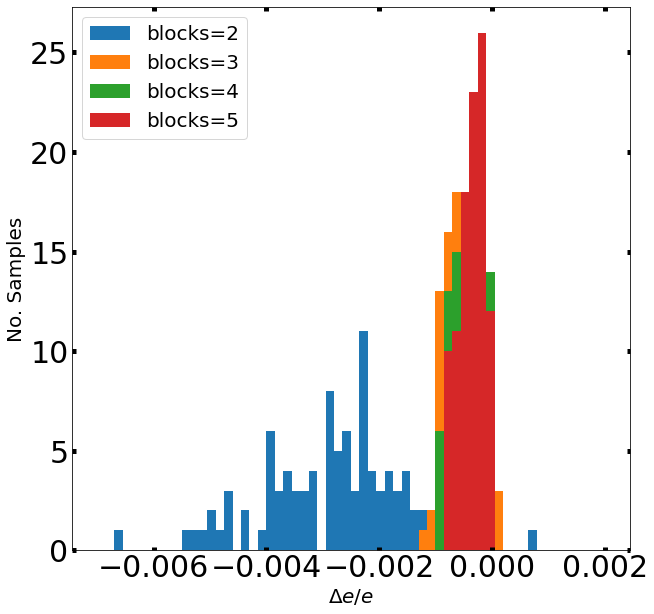

In [ ]:
plt.figure(figsize=(10,10))
for i in [0,1,2,3]:
    plt.hist(de_diff[i],bins=60,label=f'blocks={2+i}',range=(-0.007,0.002))
plt.xlabel(r'$\Delta e/e$',fontsize=20)
plt.legend(fontsize=20)
plt.ylabel('No. Samples',fontsize=20)
plt.tick_params(
            top=True,
            right=True,
            labeltop=False,
            labelright=False,
            direction="in",
            labelsize=30,
            width=5,
        )

Magnetization

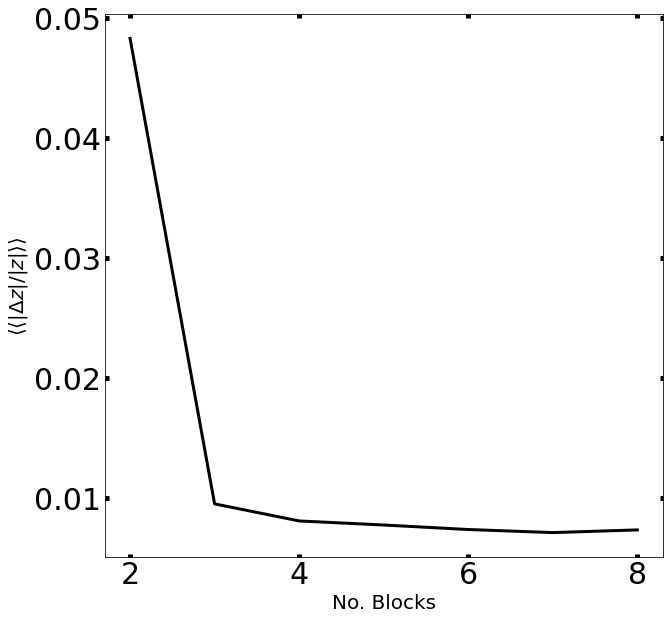

In [ ]:
blocks=np.arange(2,9)
plt.figure(figsize=(10,10))
plt.plot(blocks,np.average(dz,axis=-1),color='black',linewidth=3)
plt.xlabel('No. Blocks',fontsize=20)
plt.ylabel(r'$\langle \langle |\Delta z|/|z| \rangle \rangle$',fontsize=20)
plt.tick_params(
            top=True,
            right=True,
            labeltop=False,
            labelright=False,
            direction="in",
            labelsize=30,
            width=5,
        )

plt.show()

Histograms

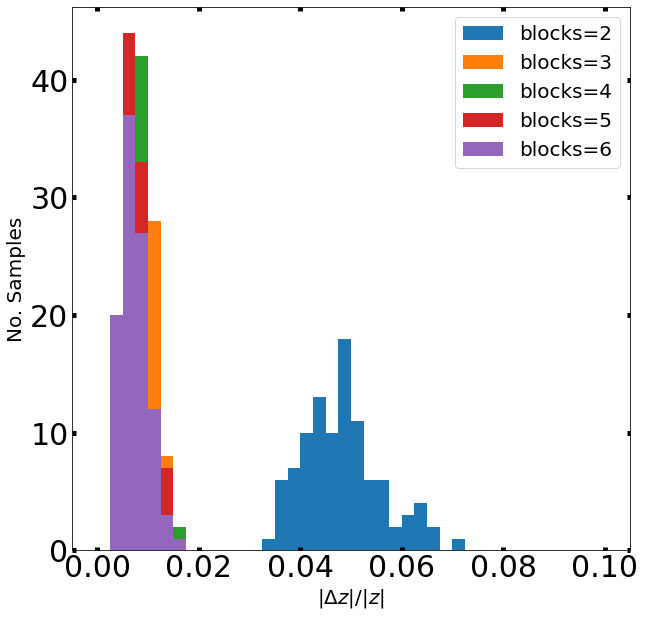

In [ ]:
plt.figure(figsize=(10,10))
for i in [0,1,2,3,4]:
    plt.hist(dz[i],bins=40,label=f'blocks={2+i}',range=(0,0.1))
plt.xlabel(r'$|\Delta z|/|z|$',fontsize=20)
plt.legend(fontsize=20)
plt.ylabel('No. Samples',fontsize=20)
plt.tick_params(
            top=True,
            right=True,
            labeltop=False,
            labelright=False,
            direction="in",
            labelsize=30,
            width=5,
        )

#### Imports

In [ ]:
import os
import time
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
from scipy import fft, ifft
from tqdm.notebook import tqdm, trange
from src.training.utils_analysis import dataloader, nuv_representability_check,mean_field_functional_1nn

#### Data

In [ ]:
n_sample=7
h_max=[2.7]*n_sample
ls=[64]*n_sample
n_instances=[100]*n_sample
epochs = [1900]*n_sample 
# model settings
name_session=[f'h_{h_max[i]}_15k_augmentation_1nn_model_unet_{ls[i]}_size_{i+2}_layers_40_hc_5_ks_1_ps' for i in range(n_sample)]
early_stopping=False
variational_lr=False
loglr=1

min_density={}
gs_density={}
min_energy={}
gs_energy={}
hs={}

for i in range(n_sample):
    min_eng=[]
    gs_eng=[]
    min_n=[]
    gs_n=[]
    hs[ls[i]]=np.load(f'data/dataset_1nn/field2density_221122/valid_unet_periodic_{ls[i]}_l_{h_max[i]}_h_200_n.npz')['potential'][0:n_instances[i]]
    min_eng_t,gs_eng_t=dataloader('energy',session_name=name_session[i],n_instances=n_instances[i],lr=loglr,diff_soglia=1,epochs=epochs[i],early_stopping=False,variable_lr=False,n_ensambles=1)
    min_n_t,gs_n_t=dataloader('density',session_name=name_session[i],n_instances=n_instances[i],lr=loglr,diff_soglia=1,epochs=epochs[i],early_stopping=False,variable_lr=False,n_ensambles=1)
    
    min_eng_t=np.asarray(min_eng_t)
    gs_eng_t=np.asarray(gs_eng_t)
    min_n_t=np.asarray(min_n_t)
    gs_n_t=np.asarray(gs_n_t)

    
    if i==0:
        min_engs=min_eng_t.reshape(1,-1)
        gs_engs=gs_eng_t.reshape(1,-1)
        min_ns=min_n_t.reshape(1,-1,ls[i])
        gs_ns=gs_n_t.reshape(1,-1,ls[i])


    else:
        
        min_engs=np.append(min_engs,min_eng_t.reshape(1,-1),axis=0)
        gs_engs=np.append(gs_engs,gs_eng_t.reshape(1,-1),axis=0)
        min_ns=np.append(min_ns,min_n_t.reshape(1,-1,ls[i]),axis=0)
        gs_ns=np.append(gs_ns,gs_n_t.reshape(1,-1,ls[i]),axis=0)
        
        


In [ ]:
print(min_engs.shape)
print(gs_engs.shape)

(7, 100)
(7, 100)


Compute the errors

In [ ]:
de=np.abs(min_engs-gs_engs)/np.abs(gs_engs)
de_diff=(gs_engs-min_engs)/(gs_engs)
dz=np.average(np.abs(min_ns-gs_ns),axis=-1)/np.average(np.abs(gs_ns),axis=-1)


#### Steady values

Energy

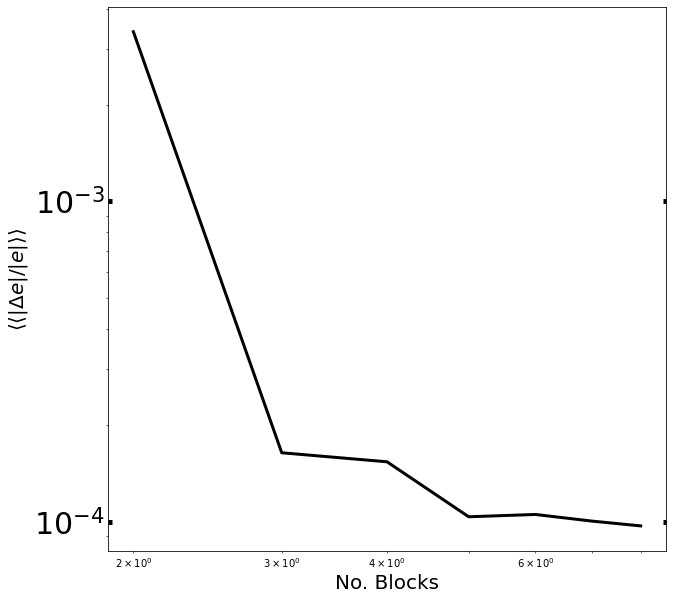

In [ ]:
blocks=np.arange(2,9)
plt.figure(figsize=(10,10))
plt.plot(blocks,np.average(de,axis=-1),color='black',linewidth=3)
plt.xlabel('No. Blocks',fontsize=20)
plt.ylabel(r'$\langle \langle |\Delta e|/|e| \rangle \rangle$',fontsize=20)
plt.tick_params(
            top=True,
            right=True,
            labeltop=False,
            labelright=False,
            direction="in",
            labelsize=30,
            width=5,
        )
plt.loglog()
plt.show()

Histograms

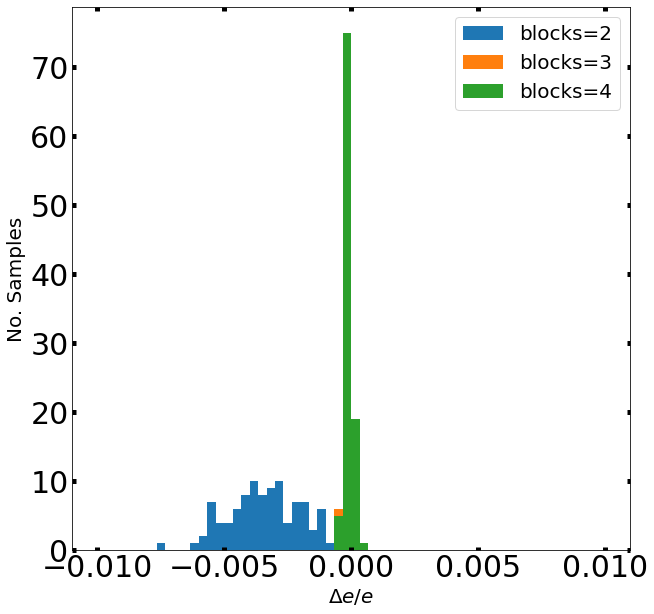

In [ ]:
plt.figure(figsize=(10,10))
for i in range(3):
    plt.hist(de_diff[i],bins=60,label=f'blocks={2+i}',range=(-0.01,0.01))
plt.xlabel(r'$\Delta e/e$',fontsize=20)
plt.legend(fontsize=20)
plt.ylabel('No. Samples',fontsize=20)
plt.tick_params(
            top=True,
            right=True,
            labeltop=False,
            labelright=False,
            direction="in",
            labelsize=30,
            width=5,
        )

Magnetization

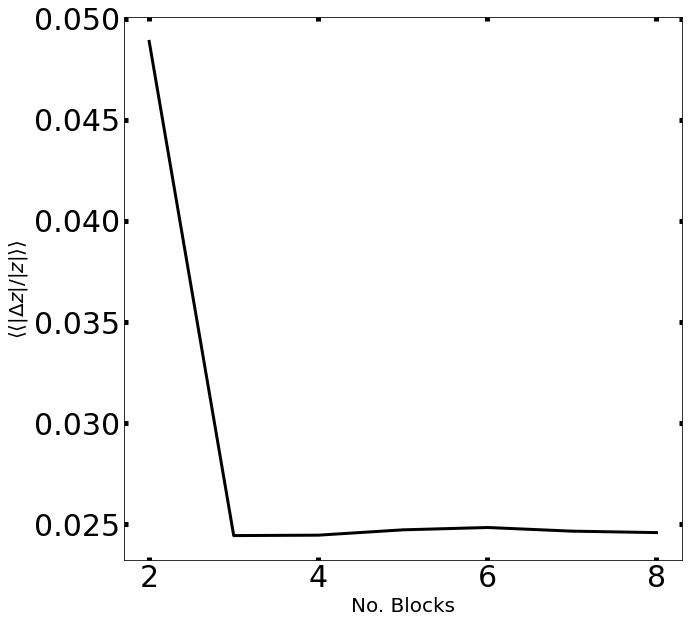

In [ ]:
blocks=np.arange(2,9)
plt.figure(figsize=(10,10))
plt.plot(blocks,np.average(dz,axis=-1),color='black',linewidth=3)
plt.xlabel('No. Blocks',fontsize=20)
plt.ylabel(r'$\langle \langle |\Delta z|/|z| \rangle \rangle$',fontsize=20)
plt.tick_params(
            top=True,
            right=True,
            labeltop=False,
            labelright=False,
            direction="in",
            labelsize=30,
            width=5,
        )

plt.show()

Histograms

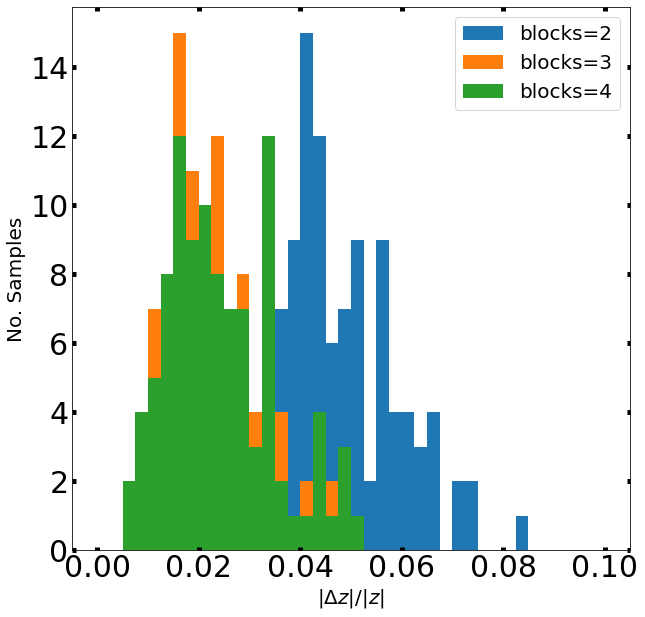

In [ ]:
plt.figure(figsize=(10,10))
for i in range(3):
    plt.hist(dz[i],bins=40,label=f'blocks={2+i}',range=(0,0.1))
plt.xlabel(r'$|\Delta z|/|z|$',fontsize=20)
plt.legend(fontsize=20)
plt.ylabel('No. Samples',fontsize=20)
plt.tick_params(
            top=True,
            right=True,
            labeltop=False,
            labelright=False,
            direction="in",
            labelsize=30,
            width=5,
        )

## DFT accuracy for different block for $l=64$

#### Imports

In [ ]:
import os
import time
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
from scipy import fft, ifft
from tqdm.notebook import tqdm, trange
from src.training.utils_analysis import dataloader, nuv_representability_check,mean_field_functional_1nn

#### Data

In [39]:
n_sample=7
h_max=[5.44]*n_sample
ls=[64]*n_sample
n_instances=[100]*n_sample
epochs = [1900]*n_sample 
# model settings
name_session=[f'h_{h_max[i]}_15k_augmentation_2nn_model_unet_{ls[i]}_size_{i+2}_layers_40_hc_5_ks_1_ps' for i in range(n_sample)]
early_stopping=False
variational_lr=False
loglr=1

min_density={}
gs_density={}
min_energy={}
gs_energy={}
hs={}

for i in range(n_sample):
    min_eng=[]
    gs_eng=[]
    min_n=[]
    gs_n=[]
    hs[ls[i]]=np.load(f'data/dataset_2nn/test_dataset_221122/test_unet_periodic_2nn_{ls[i]}_l_{h_max[i]}_h_100_n.npz')['potential'][0:n_instances[i]]
    min_eng_t,gs_eng_t=dataloader('energy',session_name=name_session[i],n_instances=n_instances[i],lr=loglr,diff_soglia=1,epochs=epochs[i],early_stopping=False,variable_lr=False,n_ensambles=1)
    min_n_t,gs_n_t=dataloader('density',session_name=name_session[i],n_instances=n_instances[i],lr=loglr,diff_soglia=1,epochs=epochs[i],early_stopping=False,variable_lr=False,n_ensambles=1)
    
    min_eng_t=np.asarray(min_eng_t)
    gs_eng_t=np.asarray(gs_eng_t)
    min_n_t=np.asarray(min_n_t)
    gs_n_t=np.asarray(gs_n_t)

    
    if i==0:
        min_engs=min_eng_t.reshape(1,-1)
        gs_engs=gs_eng_t.reshape(1,-1)
        min_ns=min_n_t.reshape(1,-1,ls[i])
        gs_ns=gs_n_t.reshape(1,-1,ls[i])


    else:
        
        min_engs=np.append(min_engs,min_eng_t.reshape(1,-1),axis=0)
        gs_engs=np.append(gs_engs,gs_eng_t.reshape(1,-1),axis=0)
        min_ns=np.append(min_ns,min_n_t.reshape(1,-1,ls[i]),axis=0)
        gs_ns=np.append(gs_ns,gs_n_t.reshape(1,-1,ls[i]),axis=0)
        
        


In [ ]:
print(min_engs.shape)
print(gs_engs.shape)

(7, 100)
(7, 100)


Compute the errors

In [42]:
de=np.abs(min_engs-gs_engs)/np.abs(gs_engs)
de_diff=(gs_engs-min_engs)/(gs_engs)
dz=np.average(np.abs(min_ns-gs_ns),axis=-1)/np.average(np.abs(gs_ns),axis=-1)


#### Steady values

Energy

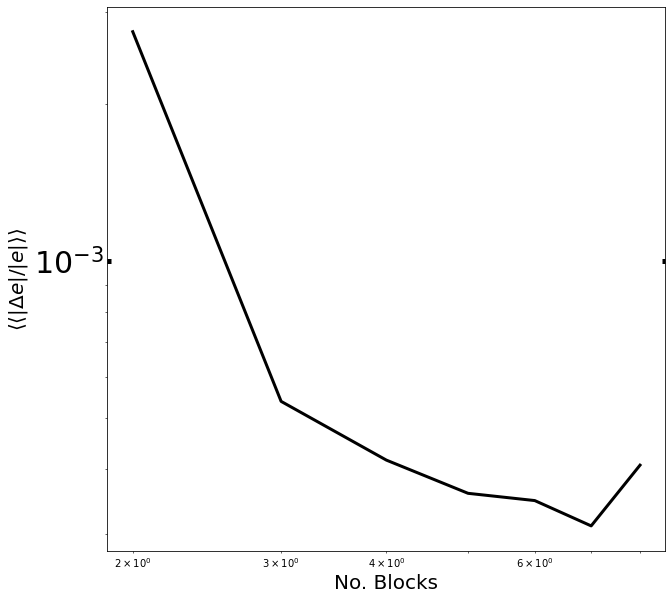

In [43]:
blocks=np.arange(2,9)
plt.figure(figsize=(10,10))
plt.plot(blocks,np.average(de,axis=-1),color='black',linewidth=3)
plt.xlabel('No. Blocks',fontsize=20)
plt.ylabel(r'$\langle \langle |\Delta e|/|e| \rangle \rangle$',fontsize=20)
plt.tick_params(
            top=True,
            right=True,
            labeltop=False,
            labelright=False,
            direction="in",
            labelsize=30,
            width=5,
        )
plt.loglog()
plt.show()

Histograms

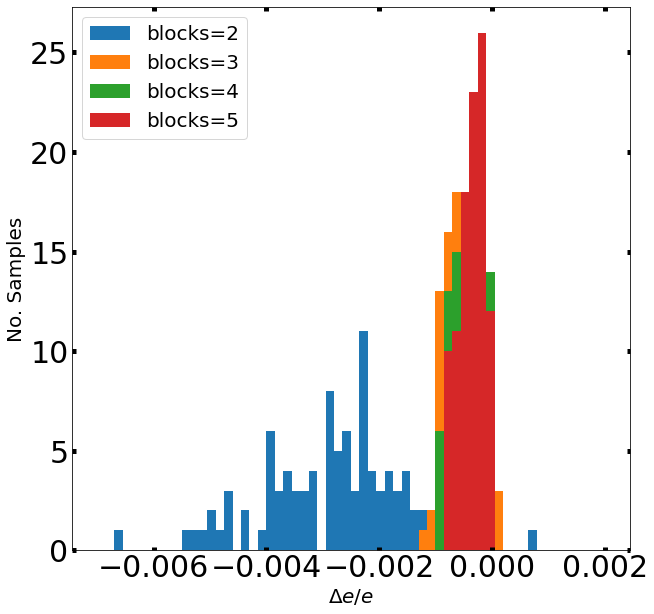

In [47]:
plt.figure(figsize=(10,10))
for i in [0,1,2,3]:
    plt.hist(de_diff[i],bins=60,label=f'blocks={2+i}',range=(-0.007,0.002))
plt.xlabel(r'$\Delta e/e$',fontsize=20)
plt.legend(fontsize=20)
plt.ylabel('No. Samples',fontsize=20)
plt.tick_params(
            top=True,
            right=True,
            labeltop=False,
            labelright=False,
            direction="in",
            labelsize=30,
            width=5,
        )

Magnetization

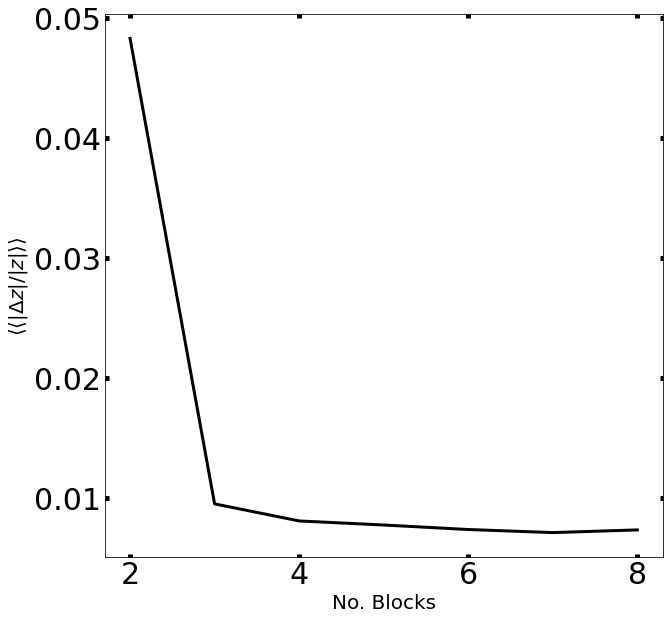

In [ ]:
blocks=np.arange(2,9)
plt.figure(figsize=(10,10))
plt.plot(blocks,np.average(dz,axis=-1),color='black',linewidth=3)
plt.xlabel('No. Blocks',fontsize=20)
plt.ylabel(r'$\langle \langle |\Delta z|/|z| \rangle \rangle$',fontsize=20)
plt.tick_params(
            top=True,
            right=True,
            labeltop=False,
            labelright=False,
            direction="in",
            labelsize=30,
            width=5,
        )

plt.show()

Histograms

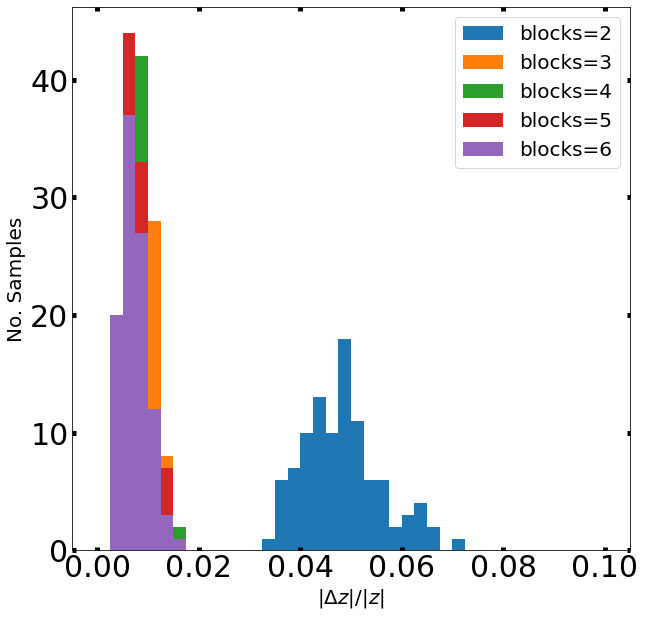

In [49]:
plt.figure(figsize=(10,10))
for i in [0,1,2,3,4]:
    plt.hist(dz[i],bins=40,label=f'blocks={2+i}',range=(0,0.1))
plt.xlabel(r'$|\Delta z|/|z|$',fontsize=20)
plt.legend(fontsize=20)
plt.ylabel('No. Samples',fontsize=20)
plt.tick_params(
            top=True,
            right=True,
            labeltop=False,
            labelright=False,
            direction="in",
            labelsize=30,
            width=5,
        )

#### Imports

In [5]:
import os
import time
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
from scipy import fft, ifft
from tqdm.notebook import tqdm, trange
from src.training.utils_analysis import dataloader, nuv_representability_check,mean_field_functional_1nn

#### Data

In [6]:
n_sample=7
h_max=[2.7]*n_sample
ls=[64]*n_sample
n_instances=[100]*n_sample
epochs = [1900]*n_sample 
# model settings
name_session=[f'h_{h_max[i]}_15k_augmentation_1nn_model_unet_{ls[i]}_size_{i+2}_layers_40_hc_5_ks_1_ps' for i in range(n_sample)]
early_stopping=False
variational_lr=False
loglr=1

min_density={}
gs_density={}
min_energy={}
gs_energy={}
hs={}

for i in range(n_sample):
    min_eng=[]
    gs_eng=[]
    min_n=[]
    gs_n=[]
    hs[ls[i]]=np.load(f'data/dataset_1nn/field2density_221122/valid_unet_periodic_{ls[i]}_l_{h_max[i]}_h_200_n.npz')['potential'][0:n_instances[i]]
    min_eng_t,gs_eng_t=dataloader('energy',session_name=name_session[i],n_instances=n_instances[i],lr=loglr,diff_soglia=1,epochs=epochs[i],early_stopping=False,variable_lr=False,n_ensambles=1)
    min_n_t,gs_n_t=dataloader('density',session_name=name_session[i],n_instances=n_instances[i],lr=loglr,diff_soglia=1,epochs=epochs[i],early_stopping=False,variable_lr=False,n_ensambles=1)
    
    min_eng_t=np.asarray(min_eng_t)
    gs_eng_t=np.asarray(gs_eng_t)
    min_n_t=np.asarray(min_n_t)
    gs_n_t=np.asarray(gs_n_t)

    
    if i==0:
        min_engs=min_eng_t.reshape(1,-1)
        gs_engs=gs_eng_t.reshape(1,-1)
        min_ns=min_n_t.reshape(1,-1,ls[i])
        gs_ns=gs_n_t.reshape(1,-1,ls[i])


    else:
        
        min_engs=np.append(min_engs,min_eng_t.reshape(1,-1),axis=0)
        gs_engs=np.append(gs_engs,gs_eng_t.reshape(1,-1),axis=0)
        min_ns=np.append(min_ns,min_n_t.reshape(1,-1,ls[i]),axis=0)
        gs_ns=np.append(gs_ns,gs_n_t.reshape(1,-1,ls[i]),axis=0)
        
        


In [7]:
print(min_engs.shape)
print(gs_engs.shape)

(7, 100)
(7, 100)


Compute the errors

In [8]:
de=np.abs(min_engs-gs_engs)/np.abs(gs_engs)
de_diff=(gs_engs-min_engs)/(gs_engs)
dz=np.average(np.abs(min_ns-gs_ns),axis=-1)/np.average(np.abs(gs_ns),axis=-1)


#### Steady values

Energy

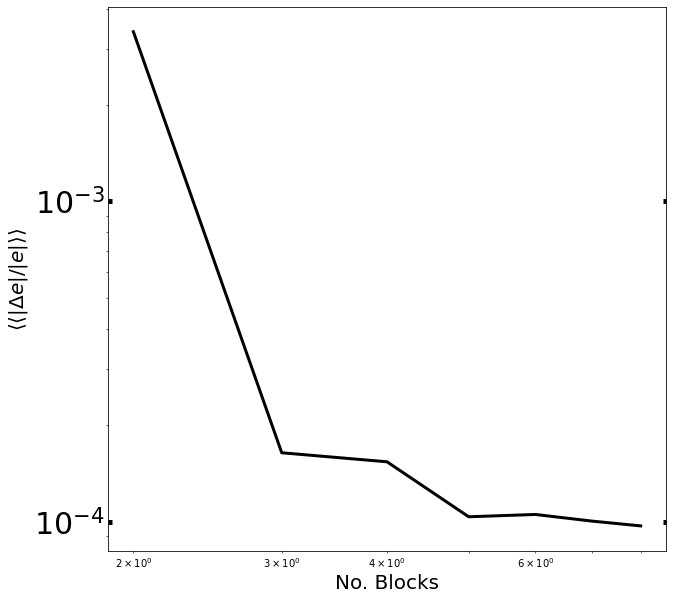

In [9]:
blocks=np.arange(2,9)
plt.figure(figsize=(10,10))
plt.plot(blocks,np.average(de,axis=-1),color='black',linewidth=3)
plt.xlabel('No. Blocks',fontsize=20)
plt.ylabel(r'$\langle \langle |\Delta e|/|e| \rangle \rangle$',fontsize=20)
plt.tick_params(
            top=True,
            right=True,
            labeltop=False,
            labelright=False,
            direction="in",
            labelsize=30,
            width=5,
        )
plt.loglog()
plt.show()

Histograms

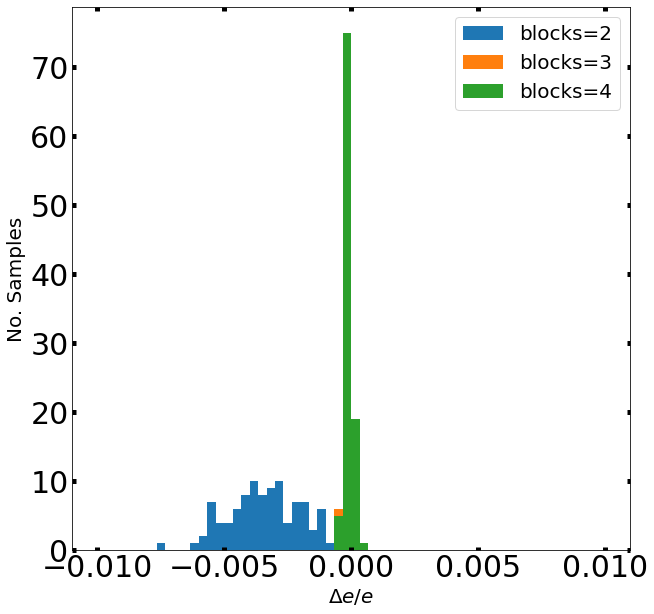

In [10]:
plt.figure(figsize=(10,10))
for i in range(3):
    plt.hist(de_diff[i],bins=60,label=f'blocks={2+i}',range=(-0.01,0.01))
plt.xlabel(r'$\Delta e/e$',fontsize=20)
plt.legend(fontsize=20)
plt.ylabel('No. Samples',fontsize=20)
plt.tick_params(
            top=True,
            right=True,
            labeltop=False,
            labelright=False,
            direction="in",
            labelsize=30,
            width=5,
        )

Magnetization

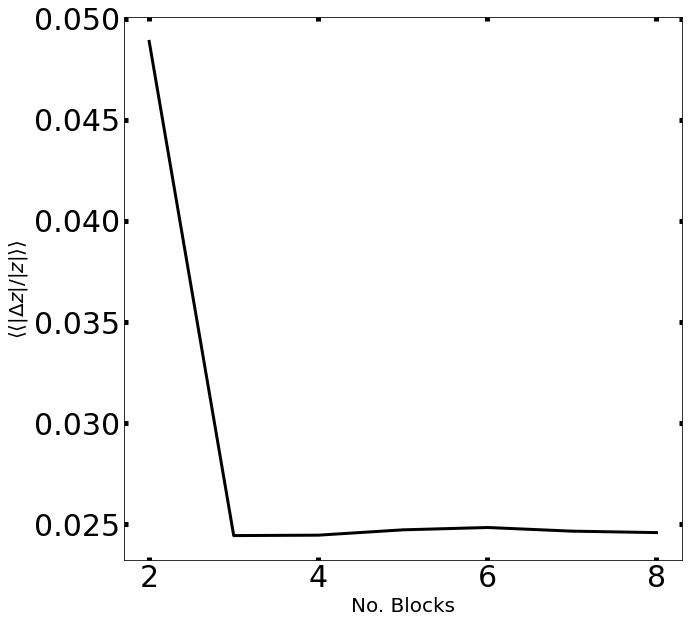

In [11]:
blocks=np.arange(2,9)
plt.figure(figsize=(10,10))
plt.plot(blocks,np.average(dz,axis=-1),color='black',linewidth=3)
plt.xlabel('No. Blocks',fontsize=20)
plt.ylabel(r'$\langle \langle |\Delta z|/|z| \rangle \rangle$',fontsize=20)
plt.tick_params(
            top=True,
            right=True,
            labeltop=False,
            labelright=False,
            direction="in",
            labelsize=30,
            width=5,
        )

plt.show()

Histograms

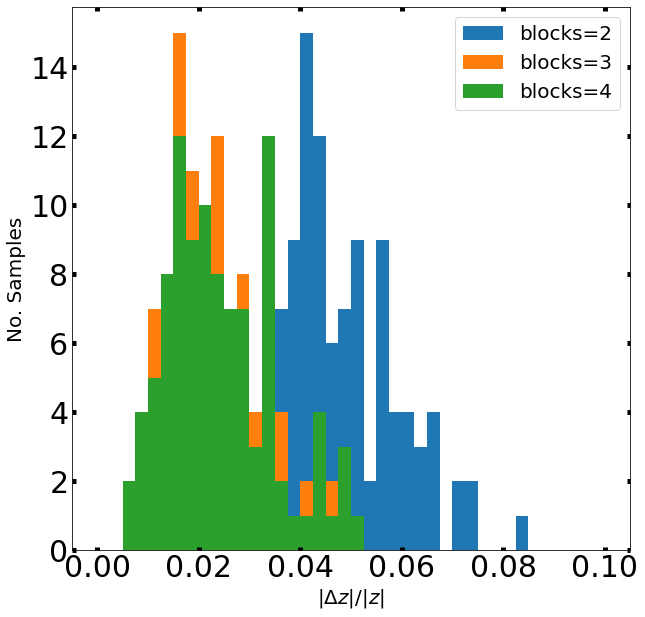

In [12]:
plt.figure(figsize=(10,10))
for i in range(3):
    plt.hist(dz[i],bins=40,label=f'blocks={2+i}',range=(0,0.1))
plt.xlabel(r'$|\Delta z|/|z|$',fontsize=20)
plt.legend(fontsize=20)
plt.ylabel('No. Samples',fontsize=20)
plt.tick_params(
            top=True,
            right=True,
            labeltop=False,
            labelright=False,
            direction="in",
            labelsize=30,
            width=5,
        )

## DFT accuracy for model trained with different sizes

#### Imports

In [1]:
import os
import time
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
from scipy import fft, ifft
from tqdm.notebook import tqdm, trange
from src.training.utils_analysis import dataloader, nuv_representability_check,mean_field_functional_1nn

#### Data

In [2]:
l_train=[8,12,18,24]

ls=[8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32]+list(range(33,64))
#ls=np.arange(8,65)
n_sample=len(ls)
ks=[5]*n_sample
n_sample=len(ks)
h_max=[2.7]*n_sample
n_instances=[100]*n_sample
epochs = [4900]*n_sample
# model settings
name_session={}
for l in l_train:
    if l=='standard':
        name_session[16]=[f'h_{h_max[i]}_150k_augmentation_1nn_model_unet_{ls[i]}_size_4_layers_40_hc_{ks[i]}_ks_1_ps' for i in range(n_sample)]
    else:
        name_session[l]=[f'h_{h_max[i]}_l_train_{l}_150k_augmentation_1nn_model_unet_{ls[i]}_size_4_layers_40_hc_{ks[i]}_ks_1_ps' for i in range(n_sample)]


early_stopping=False
variational_lr=False
loglr=1

min_density={}
gs_density={}
min_energy={}
gs_energy={}
hs={}

#train l selected
de={}
de_diff={}
dz={}
for r in l_train:
    for i in range(n_sample):
        min_eng=[]
        gs_eng=[]
        min_n=[]
        gs_n=[]
        hs[ls[i]]=np.load(f'data/dataset_1nn/field2density_221122/valid_unet_periodic_{ls[i]}_l_{h_max[i]}_h_200_n.npz')['potential'][0:n_instances[i]]
        min_eng_t,gs_eng_t=dataloader('energy',session_name=name_session[r][i],n_instances=n_instances[i],lr=loglr,diff_soglia=1,epochs=epochs[i],early_stopping=False,variable_lr=False,n_ensambles=1)
        min_n_t,gs_n_t=dataloader('density',session_name=name_session[r][i],n_instances=n_instances[i],lr=loglr,diff_soglia=1,epochs=epochs[i],early_stopping=False,variable_lr=False,n_ensambles=1)
        
        min_eng_t=np.asarray(min_eng_t)
        gs_eng_t=np.asarray(gs_eng_t)
        min_n_t=np.asarray(min_n_t)
        gs_n_t=np.asarray(gs_n_t)

        min_energy[ls[i]]=min_eng_t.reshape(-1)
        gs_energy[ls[i]]=gs_eng_t.reshape(-1)
        print(min_n_t.shape)
        
        min_density[ls[i]]=min_n_t#.reshape(-1,ls[i])
        gs_density[ls[i]]=gs_n_t#.reshape(-1,ls[i])
        
        # plt.plot(min_density[ls[i]][0])
        # plt.plot(gs_density[ls[i]][0])
        # plt.title(f'l={ls[i]}, r={r}')
        # plt.show()     
    
    de[r]=[np.abs(min_energy[l]-gs_energy[l])/np.abs(gs_energy[l]) for l in ls]
    de_diff[r]=[(gs_energy[l]-min_energy[l])/(gs_energy[l]) for l in ls]
    dz[r]=[np.average(np.abs(min_density[l]-gs_density[l]),axis=-1)/np.average(np.abs(gs_density[l]),axis=-1) for l in ls]   


(55, 8)
(54, 9)
(55, 10)
(54, 11)
(55, 12)
(53, 13)
(54, 14)
(53, 15)
(53, 16)
(53, 17)
(53, 18)
(52, 19)
(52, 20)
(52, 21)
(52, 22)
(51, 23)
(53, 24)
(52, 25)
(52, 26)
(52, 27)
(52, 28)
(51, 29)
(51, 30)
(51, 31)
(51, 32)
(100, 33)
(100, 34)
(100, 35)
(100, 36)
(100, 37)
(100, 38)
(100, 39)
(100, 40)
(100, 41)
(100, 42)
(100, 43)
(100, 44)
(100, 45)
(100, 46)
(100, 47)
(100, 48)
(100, 49)
(100, 50)
(100, 51)
(100, 52)
(100, 53)
(100, 54)
(100, 55)
(100, 56)
(100, 57)
(100, 58)
(100, 59)
(100, 60)
(100, 61)
(100, 62)
(100, 63)
(55, 8)
(54, 9)
(54, 10)
(54, 11)
(55, 12)
(54, 13)
(54, 14)
(53, 15)
(53, 16)
(53, 17)
(52, 18)
(52, 19)
(52, 20)
(52, 21)
(51, 22)
(52, 23)
(53, 24)
(52, 25)
(52, 26)
(51, 27)
(51, 28)
(51, 29)
(52, 30)
(51, 31)
(51, 32)
(100, 33)
(100, 34)
(100, 35)
(100, 36)
(100, 37)
(100, 38)
(100, 39)
(100, 40)
(100, 41)
(100, 42)
(100, 43)
(100, 44)
(100, 45)
(100, 46)
(100, 47)
(100, 48)
(100, 49)
(100, 50)
(100, 51)
(100, 52)
(100, 53)
(100, 54)
(100, 55)
(100, 56)
(100

In [ ]:
for l in ls:
    
    plt.plot()

#### Steady values

Energy

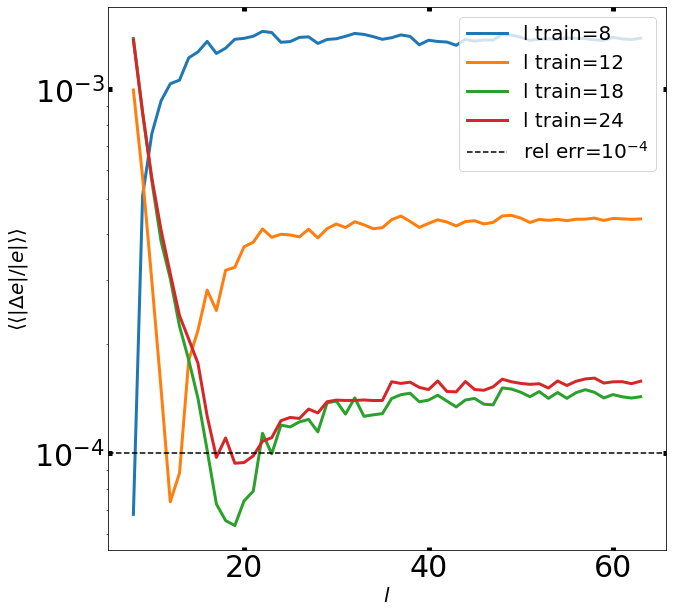

In [6]:
blocks=ls
plt.figure(figsize=(10,10))
for r in l_train:
    plt.plot(blocks,[np.average(e,axis=-1) for e in de[r]],linewidth=3,label=f'l train={r}')
plt.axhline(y=10**-4,label=r'rel err=$10^{-4}$',color='black',linestyle='--')
plt.xlabel(r'$l$',fontsize=20)
plt.ylabel(r'$\langle \langle |\Delta e|/|e| \rangle \rangle$',fontsize=20)
plt.semilogy()
plt.tick_params(
            top=True,
            right=True,
            labeltop=False,
            labelright=False,
            direction="in",
            labelsize=30,
            width=5,
        )
plt.legend(fontsize=20)
plt.show()
#print(np.average(de,axis=-1))

Histograms

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


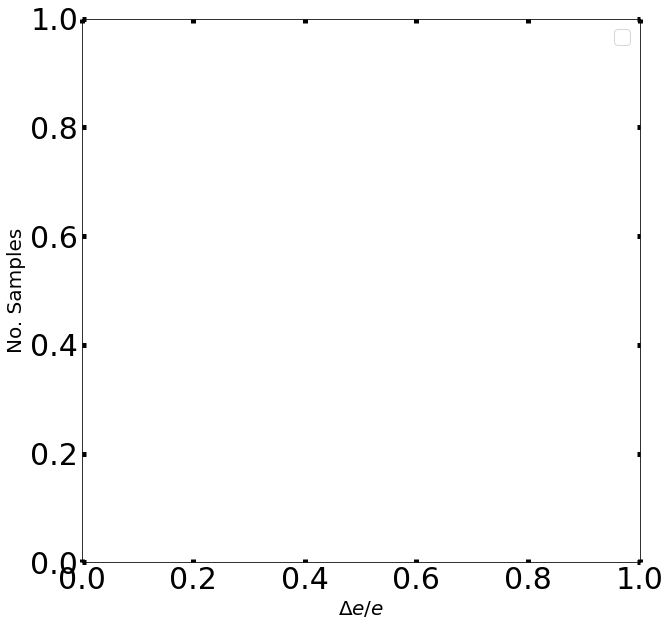

In [7]:
plt.figure(figsize=(10,10))
for i in range(6,2):
    plt.hist(de_diff[i],bins=80,label=f'l={ls[i]}',range=(-0.001,0.001))
plt.xlabel(r'$\Delta e/e$',fontsize=20)
plt.legend(fontsize=20)
plt.ylabel('No. Samples',fontsize=20)
plt.tick_params(
            top=True,
            right=True,
            labeltop=False,
            labelright=False,
            direction="in",
            labelsize=30,
            width=5,
        )

Magnetization

There is a discrepancy in the magnetization value even if the energy error seems to decrease (problem with DMRG again? Is due to the H-K mapping?)

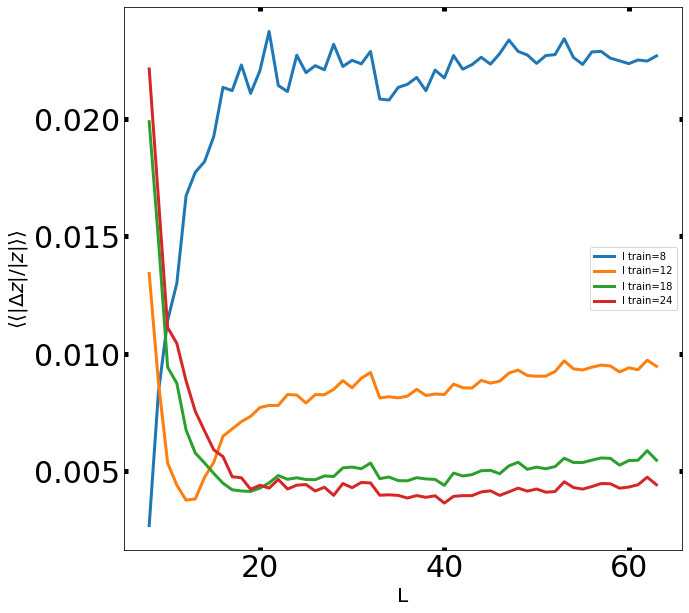

In [8]:
blocks=ls

plt.figure(figsize=(10,10))
for r in l_train:
    plt.plot(blocks,[np.average(z,axis=-1) for z in dz[r]],linewidth=3,label=f'l train={r}')
plt.xlabel('L',fontsize=20)
plt.legend()
plt.ylabel(r'$\langle \langle |\Delta z|/|z| \rangle \rangle$',fontsize=20)
plt.tick_params(
            top=True,
            right=True,
            labeltop=False,
            labelright=False,
            direction="in",
            labelsize=30,
            width=5,
        )

plt.show()

Histograms

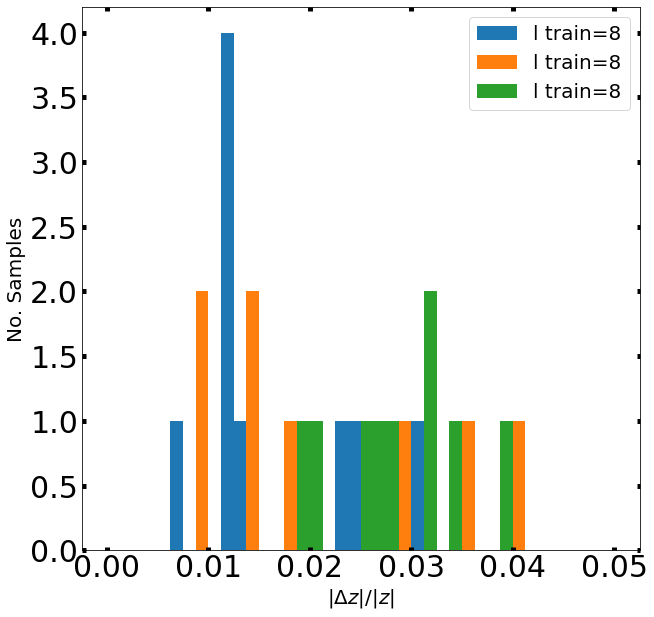

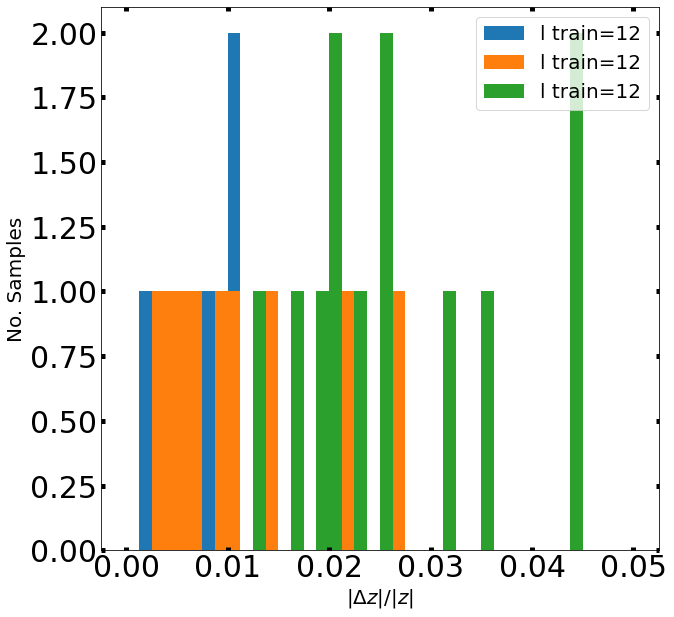

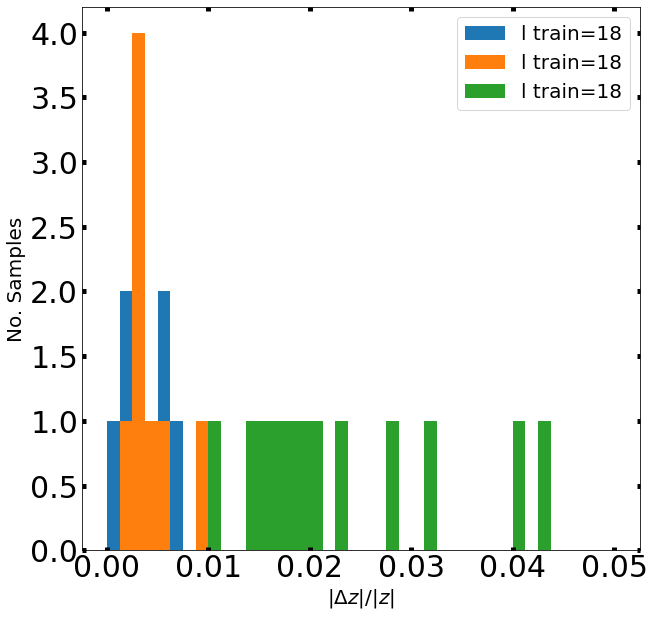

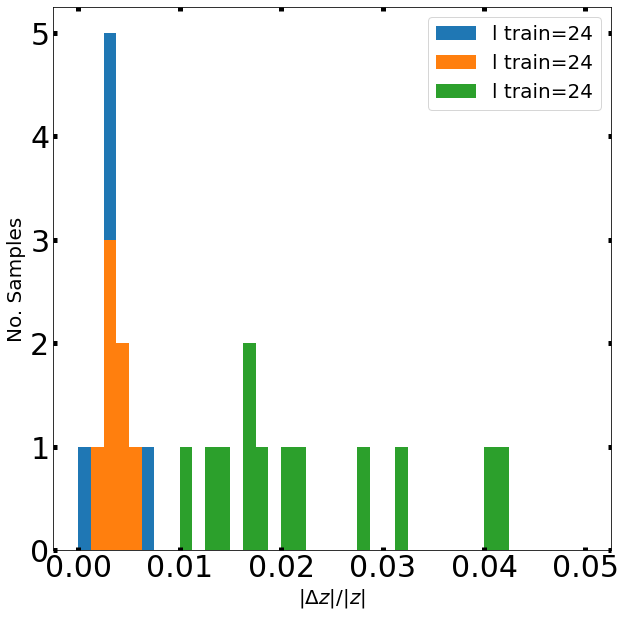

In [59]:

for r in l_train:
    plt.figure(figsize=(10,10))
    for i in [12,-2,-1]:
        plt.hist(dz[r][i],bins=40,label=f'l train={r}',range=(0,0.05))
    plt.xlabel(r'$|\Delta z|/|z|$',fontsize=20)
    plt.legend(fontsize=20)
    plt.ylabel('No. Samples',fontsize=20)
    plt.tick_params(
            top=True,
            right=True,
            labeltop=False,
            labelright=False,
            direction="in",
            labelsize=30,
            width=5,
        )
    plt.show()

## DFT accuracy for model trained with training size l=16

#### Imports

In [1]:
import os
import time
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
from scipy import fft, ifft
from tqdm.notebook import tqdm, trange
from src.training.utils_analysis import dataloader, nuv_representability_check,mean_field_functional_1nn

#### Data

In [10]:
l_train=['5k','15k','150k']

ls=[16] #also 32 and 64
#ls=np.arange(8,65)
n_sample=len(ls)
ks=[5]*n_sample
n_sample=len(ks)
h_max=[2.7]*n_sample
n_instances=[300]*n_sample
epochs = [1900]*n_sample
# model settings
name_session={}
for l in l_train:
    if l=='standard':
        name_session[16]=[f'h_2.7_l_train_{l}_150k_augmentation_1nn_model_unet_{ls[i]}_size_6_layers_40_hc_{ks[i]}_ks_1_ps' for i in range(n_sample)]
    else:
        name_session[l]=[f'h_2.7_l_train_{l}_150k_augmentation_1nn_model_unet_{ls[i]}_size_6_layers_40_hc_{ks[i]}_ks_1_ps' for i in range(n_sample)]


early_stopping=False
variational_lr=False
loglr=1

min_density={}
gs_density={}
min_energy={}
gs_energy={}
hs={}

#train l selected
de={}
de_diff={}
dz={}
for r in l_train:
    for i in range(n_sample):
        min_eng=[]
        gs_eng=[]
        min_n=[]
        gs_n=[]
        hs[ls[i]]=np.load(f'data/dataset_1nn/240123/unet_periodic_{ls[i]}_l_{h_max[i]}_h_6000_n.npz')['potential'][0:n_instances[i]]
        min_eng_t,gs_eng_t=dataloader('energy',session_name=name_session[r][i],n_instances=n_instances[i],lr=loglr,diff_soglia=1,epochs=epochs[i],early_stopping=False,variable_lr=False,n_ensambles=1)
        min_n_t,gs_n_t=dataloader('density',session_name=name_session[r][i],n_instances=n_instances[i],lr=loglr,diff_soglia=1,epochs=epochs[i],early_stopping=False,variable_lr=False,n_ensambles=1)
        
        min_eng_t=np.asarray(min_eng_t)
        gs_eng_t=np.asarray(gs_eng_t)
        min_n_t=np.asarray(min_n_t)
        gs_n_t=np.asarray(gs_n_t)

        min_energy[ls[i]]=min_eng_t.reshape(-1)
        gs_energy[ls[i]]=gs_eng_t.reshape(-1)
        print(min_n_t.shape)
        
        min_density[ls[i]]=min_n_t#.reshape(-1,ls[i])
        gs_density[ls[i]]=gs_n_t#.reshape(-1,ls[i])
        
        # plt.plot(min_density[ls[i]][0])
        # plt.plot(gs_density[ls[i]][0])
        # plt.title(f'l={ls[i]}, r={r}')
        # plt.show()     
    
    de[r]=[np.abs(min_energy[l]-gs_energy[l])/np.abs(gs_energy[l]) for l in ls]
    de_diff[r]=[(gs_energy[l]-min_energy[l])/(gs_energy[l]) for l in ls]
    dz[r]=[np.average(np.abs(min_density[l]-gs_density[l]),axis=-1)/np.average(np.abs(gs_density[l]),axis=-1) for l in ls]   


(300, 16)
(300, 16)
(300, 16)


In [ ]:
for l in ls:
    
    plt.plot()

#### Steady values

Energy

In [ ]:
blocks=ls
plt.figure(figsize=(10,10))
for r in l_train:
    plt.plot(blocks,[np.average(e,axis=-1) for e in de[r]],linewidth=3,label=f'l train={r}')
plt.axhline(y=10**-4,label=r'rel err=$10^{-4}$',color='black',linestyle='--')
plt.xlabel(r'$l$',fontsize=20)
plt.ylabel(r'$\langle \langle |\Delta e|/|e| \rangle \rangle$',fontsize=20)
plt.semilogy()
plt.tick_params(
            top=True,
            right=True,
            labeltop=False,
            labelright=False,
            direction="in",
            labelsize=30,
            width=5,
        )
plt.legend(fontsize=20)
plt.show()
#print(np.average(de,axis=-1))

Histograms

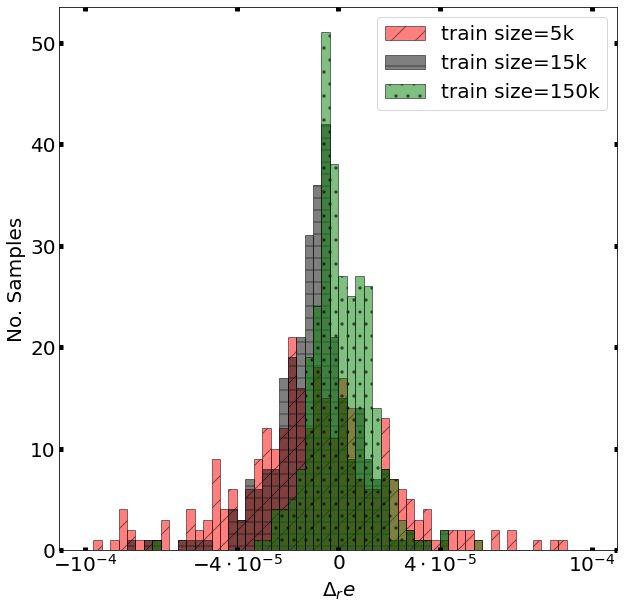

In [49]:
plt.figure(figsize=(10,10))
hatchs=['/','-','.']
colors=['red','black','green']
for j,r in enumerate(l_train):
    for i in [-1]:
        plt.hist(de_diff[r][i],bins=60,label=f'train size={r}',range=(-0.0001,0.0001),alpha=0.5,hatch=hatchs[j], edgecolor='k',fill=True,color=colors[j])
plt.xlabel(r'$\Delta_r e$',fontsize=20)
plt.xticks([-0.0001,-0.00004,0.,0.00004,0.0001],[r'$ -10^{-4}$',r'$-4 \cdot 10^{-5}$',r'$0$',r'$4 \cdot 10^{-5}$',r'$  10^{-4}$'])
plt.legend(fontsize=20)
plt.ylabel('No. Samples',fontsize=20)
plt.tick_params(
        top=True,
        right=True,
        labeltop=False,
        labelright=False,
        direction="in",
        labelsize=20,
        width=5,
    )
plt.show()

Magnetization

There is a discrepancy in the magnetization value even if the energy error seems to decrease (problem with DMRG again? Is due to the H-K mapping?)

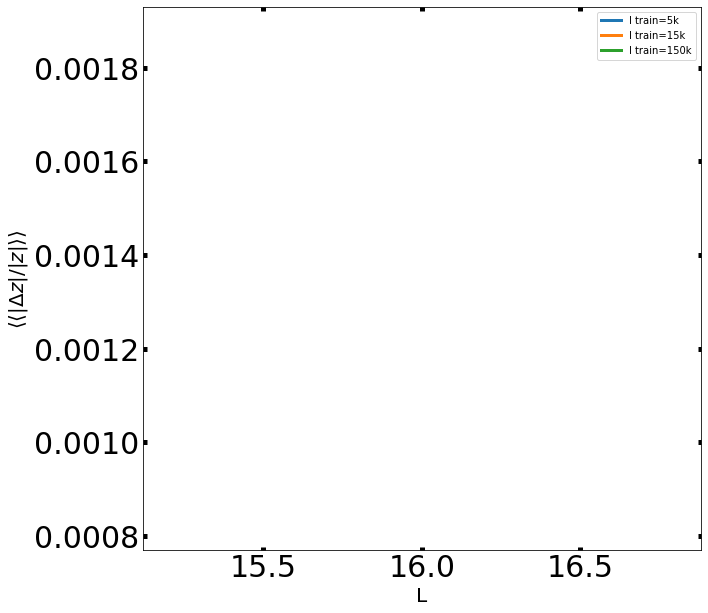

In [9]:
blocks=ls

plt.figure(figsize=(10,10))
for r in l_train:
    plt.plot(blocks,[np.average(z,axis=-1) for z in dz[r]],linewidth=3,label=f'l train={r}')
plt.xlabel('L',fontsize=20)
plt.legend()
plt.ylabel(r'$\langle \langle |\Delta z|/|z| \rangle \rangle$',fontsize=20)
plt.tick_params(
            top=True,
            right=True,
            labeltop=False,
            labelright=False,
            direction="in",
            labelsize=30,
            width=5,
        )

plt.show()

Histograms

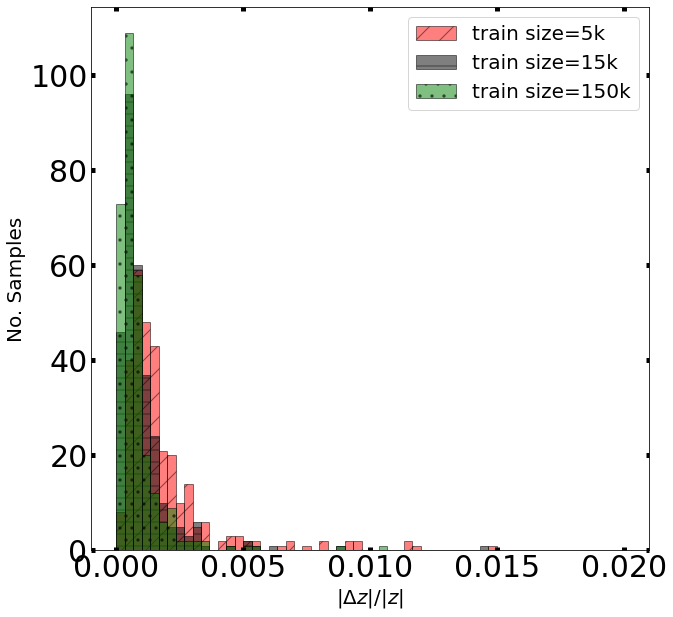

In [32]:
plt.figure(figsize=(10,10))
hatchs=['/','-','.']
colors=['red','black','green']
for j,r in enumerate(l_train):
    for i in [-1]:
        plt.hist(dz[r][i],bins=60,label=f'train size={r}',range=(0,0.02),alpha=0.5,hatch=hatchs[j], edgecolor='k',fill=True,color=colors[j])
plt.xlabel(r'$|\Delta z|/|z|$',fontsize=20)
plt.legend(fontsize=20)
plt.ylabel('No. Samples',fontsize=20)
plt.tick_params(
        top=True,
        right=True,
        labeltop=False,
        labelright=False,
        direction="in",
        labelsize=30,
        width=5,
    )
plt.show()

## DFT accuracy for model trained with training size l=64

#### Imports

In [ ]:
import os
import time
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
from scipy import fft, ifft
from tqdm.notebook import tqdm, trange
from src.training.utils_analysis import dataloader, nuv_representability_check,mean_field_functional_1nn

#### Data

In [50]:
l_train=['5k','15k','150k']

ls=[64] #also 32 and 64
#ls=np.arange(8,65)
n_sample=len(ls)
ks=[5]*n_sample
n_sample=len(ks)
h_max=[2.7]*n_sample
n_instances=[300]*n_sample
epochs = [1900]*n_sample
# model settings
name_session={}
for l in l_train:
    if l=='standard':
        name_session[16]=[f'h_2.7_l_train_{l}_150k_augmentation_1nn_model_unet_{ls[i]}_size_6_layers_40_hc_{ks[i]}_ks_1_ps' for i in range(n_sample)]
    else:
        name_session[l]=[f'h_2.7_l_train_{l}_150k_augmentation_1nn_model_unet_{ls[i]}_size_6_layers_40_hc_{ks[i]}_ks_1_ps' for i in range(n_sample)]


early_stopping=False
variational_lr=False
loglr=1

min_density={}
gs_density={}
min_energy={}
gs_energy={}
hs={}

#train l selected
de={}
de_diff={}
dz={}
for r in l_train:
    for i in range(n_sample):
        min_eng=[]
        gs_eng=[]
        min_n=[]
        gs_n=[]
        hs[ls[i]]=np.load(f'data/dataset_1nn/240123/unet_periodic_{ls[i]}_l_{h_max[i]}_h_6000_n.npz')['potential'][0:n_instances[i]]
        min_eng_t,gs_eng_t=dataloader('energy',session_name=name_session[r][i],n_instances=n_instances[i],lr=loglr,diff_soglia=1,epochs=epochs[i],early_stopping=False,variable_lr=False,n_ensambles=1)
        min_n_t,gs_n_t=dataloader('density',session_name=name_session[r][i],n_instances=n_instances[i],lr=loglr,diff_soglia=1,epochs=epochs[i],early_stopping=False,variable_lr=False,n_ensambles=1)
        
        min_eng_t=np.asarray(min_eng_t)
        gs_eng_t=np.asarray(gs_eng_t)
        min_n_t=np.asarray(min_n_t)
        gs_n_t=np.asarray(gs_n_t)

        min_energy[ls[i]]=min_eng_t.reshape(-1)
        gs_energy[ls[i]]=gs_eng_t.reshape(-1)
        print(min_n_t.shape)
        
        min_density[ls[i]]=min_n_t#.reshape(-1,ls[i])
        gs_density[ls[i]]=gs_n_t#.reshape(-1,ls[i])
        
        # plt.plot(min_density[ls[i]][0])
        # plt.plot(gs_density[ls[i]][0])
        # plt.title(f'l={ls[i]}, r={r}')
        # plt.show()     
    
    de[r]=[np.abs(min_energy[l]-gs_energy[l])/np.abs(gs_energy[l]) for l in ls]
    de_diff[r]=[(gs_energy[l]-min_energy[l])/(gs_energy[l]) for l in ls]
    dz[r]=[np.average(np.abs(min_density[l]-gs_density[l]),axis=-1)/np.average(np.abs(gs_density[l]),axis=-1) for l in ls]   


(300, 64)
(300, 64)
(300, 64)


In [ ]:
for l in ls:
    
    plt.plot()

#### Steady values

Energy

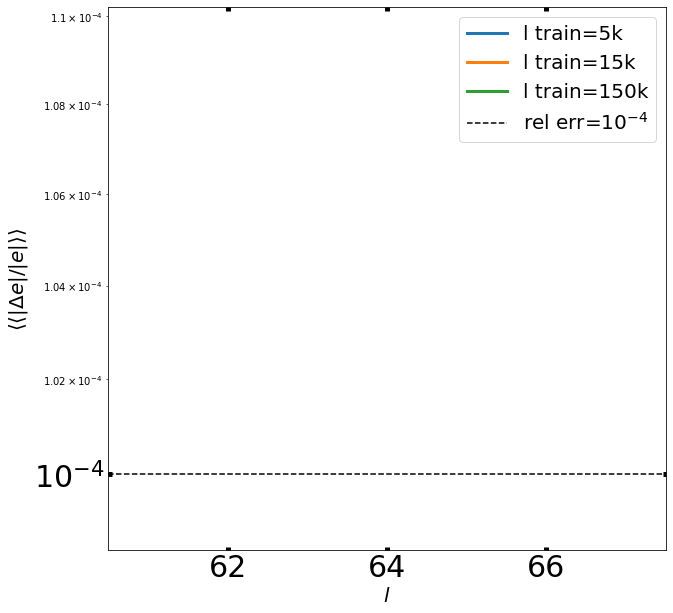

In [51]:
blocks=ls
plt.figure(figsize=(10,10))
for r in l_train:
    plt.plot(blocks,[np.average(e,axis=-1) for e in de[r]],linewidth=3,label=f'l train={r}')
plt.axhline(y=10**-4,label=r'rel err=$10^{-4}$',color='black',linestyle='--')
plt.xlabel(r'$l$',fontsize=20)
plt.ylabel(r'$\langle \langle |\Delta e|/|e| \rangle \rangle$',fontsize=20)
plt.semilogy()
plt.tick_params(
            top=True,
            right=True,
            labeltop=False,
            labelright=False,
            direction="in",
            labelsize=30,
            width=5,
        )
plt.legend(fontsize=20)
plt.show()
#print(np.average(de,axis=-1))

Histograms

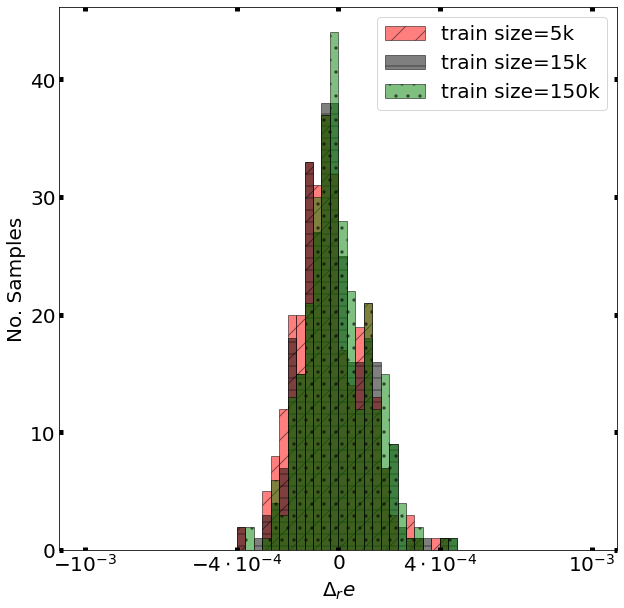

In [53]:
plt.figure(figsize=(10,10))
hatchs=['/','-','.']
colors=['red','black','green']
for j,r in enumerate(l_train):
    for i in [-1]:
        plt.hist(de_diff[r][i],bins=60,label=f'train size={r}',range=(-0.001,0.001),alpha=0.5,hatch=hatchs[j], edgecolor='k',fill=True,color=colors[j])
plt.xlabel(r'$\Delta_r e$',fontsize=20)
plt.xticks([-0.001,-0.0004,0.,0.0004,0.001],[r'$ -10^{-3}$',r'$-4 \cdot 10^{-4}$',r'$0$',r'$4 \cdot 10^{-4}$',r'$  10^{-3}$'])
plt.legend(fontsize=20)
plt.ylabel('No. Samples',fontsize=20)
plt.tick_params(
        top=True,
        right=True,
        labeltop=False,
        labelright=False,
        direction="in",
        labelsize=20,
        width=5,
    )
plt.show()

Magnetization

There is a discrepancy in the magnetization value even if the energy error seems to decrease (problem with DMRG again? Is due to the H-K mapping?)

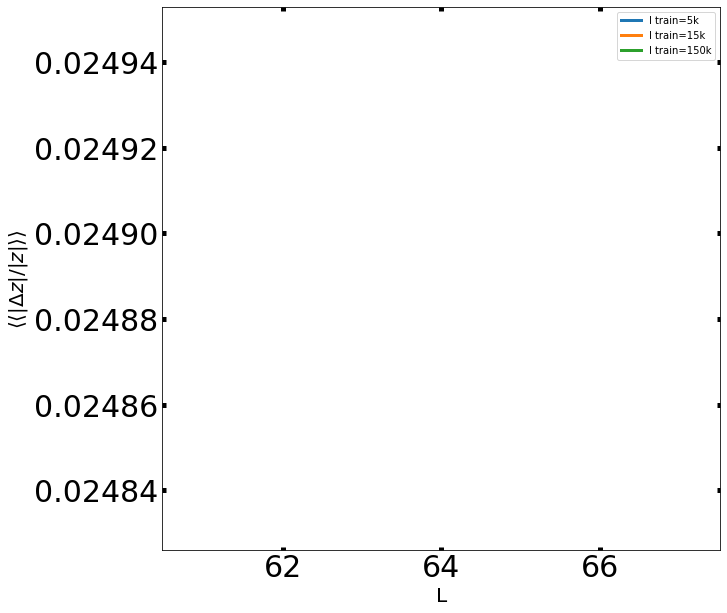

In [54]:
blocks=ls

plt.figure(figsize=(10,10))
for r in l_train:
    plt.plot(blocks,[np.average(z,axis=-1) for z in dz[r]],linewidth=3,label=f'l train={r}')
plt.xlabel('L',fontsize=20)
plt.legend()
plt.ylabel(r'$\langle \langle |\Delta z|/|z| \rangle \rangle$',fontsize=20)
plt.tick_params(
            top=True,
            right=True,
            labeltop=False,
            labelright=False,
            direction="in",
            labelsize=30,
            width=5,
        )

plt.show()

Histograms

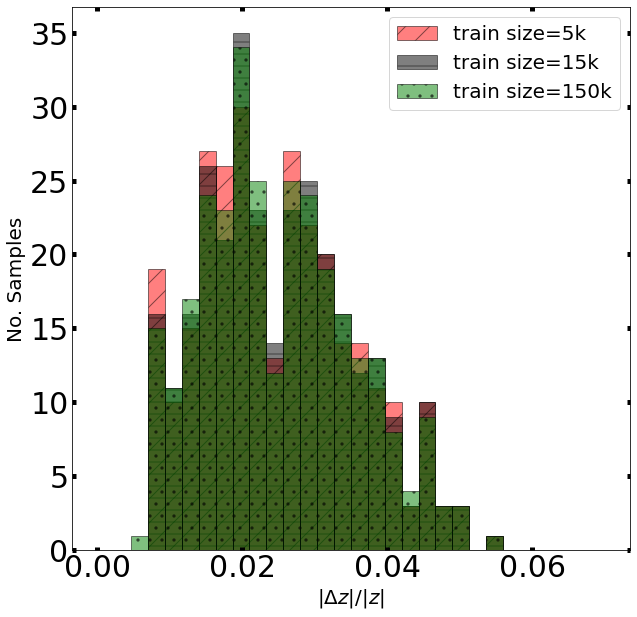

In [58]:
plt.figure(figsize=(10,10))
hatchs=['/','-','.']
colors=['red','black','green']
for j,r in enumerate(l_train):
    for i in [-1]:
        plt.hist(dz[r][i],bins=30,label=f'train size={r}',range=(0,0.07),alpha=0.5,hatch=hatchs[j], edgecolor='k',fill=True,color=colors[j])
plt.xlabel(r'$|\Delta z|/|z|$',fontsize=20)
plt.legend(fontsize=20)
plt.ylabel('No. Samples',fontsize=20)
plt.tick_params(
        top=True,
        right=True,
        labeltop=False,
        labelright=False,
        direction="in",
        labelsize=30,
        width=5,
    )
plt.show()